# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Data Exploration - general population vs. customers

#### Load general population and customers dataset

In [2]:
# load in the data
# general population dataset
azdias_df = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

# customers dataset
customers_df = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/fc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [6]:
customers_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


`azdias_df` and `customers_df` have 366 common features, which is the same as `azdias_df` features.

In [7]:
np.intersect1d(azdias_df.columns.values, customers_df.columns.values).shape

(366,)

create `only_attr_customers` to hold `customer_df` only features

In [8]:
only_attr_customers = np.setdiff1d(customers_df.columns.values, azdias_df.columns.values)

CUSTOMER_GROUP distribution

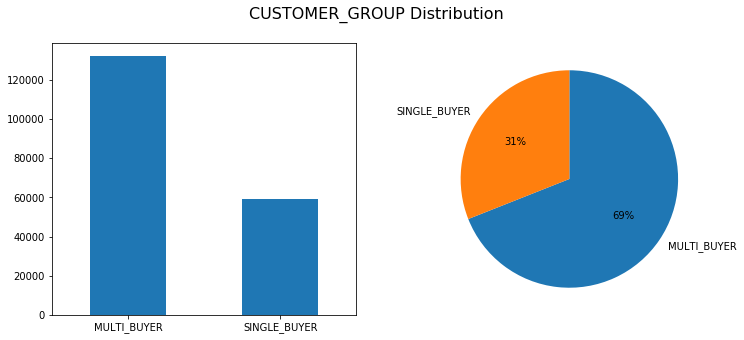

In [9]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.CUSTOMER_GROUP.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.CUSTOMER_GROUP.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('CUSTOMER_GROUP Distribution', fontsize=16)
plt.show()

ONLINE_PURCHASE distribution

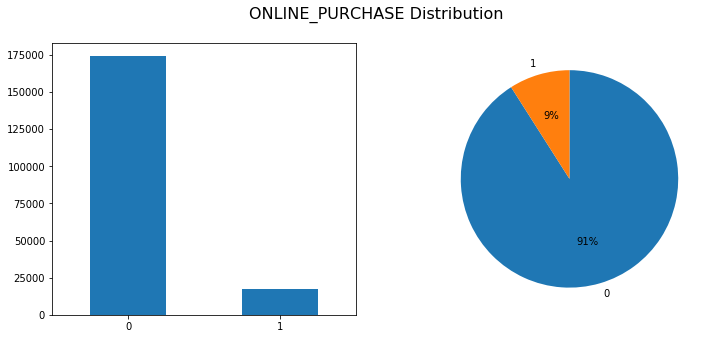

In [10]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.ONLINE_PURCHASE.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.ONLINE_PURCHASE.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('ONLINE_PURCHASE Distribution', fontsize=16)
plt.show()

PRODUCT_GROUP distribution

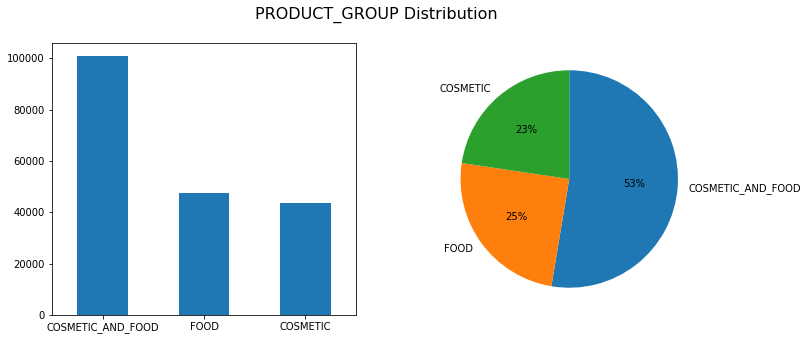

In [11]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.PRODUCT_GROUP.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.PRODUCT_GROUP.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('PRODUCT_GROUP Distribution', fontsize=16)
plt.show()

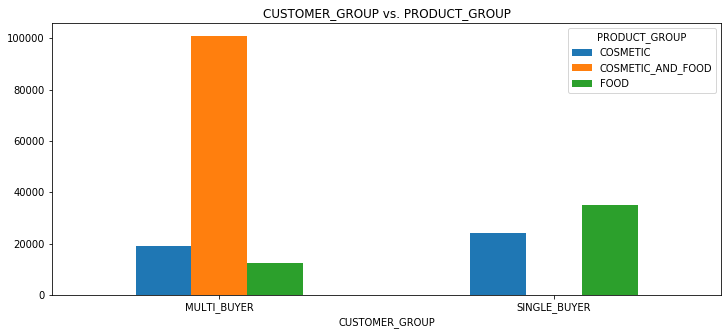

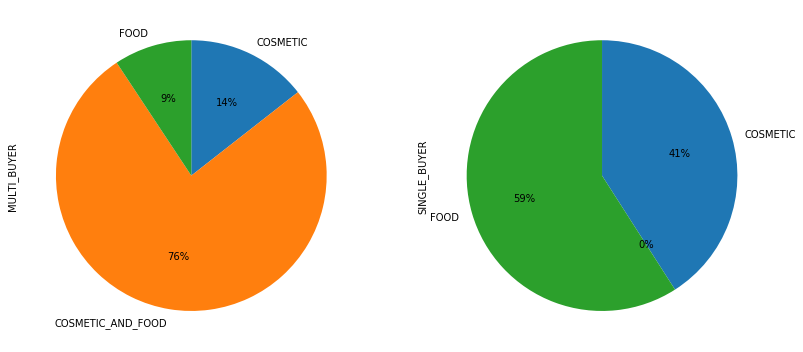

In [12]:
customers_df.groupby(['CUSTOMER_GROUP'])['PRODUCT_GROUP'].value_counts().unstack().plot.bar(figsize = [12, 5], rot=0).set_title('CUSTOMER_GROUP vs. PRODUCT_GROUP')

customers_df.groupby(['CUSTOMER_GROUP'])['PRODUCT_GROUP'].value_counts().unstack().T.plot.pie(subplots=True, autopct='%1.f%%', figsize=[12,5], legend=False, startangle = 90, counterclock = False)

plt.tight_layout()
plt.show()

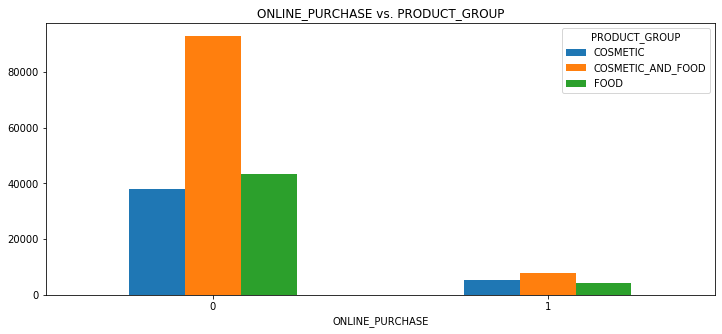

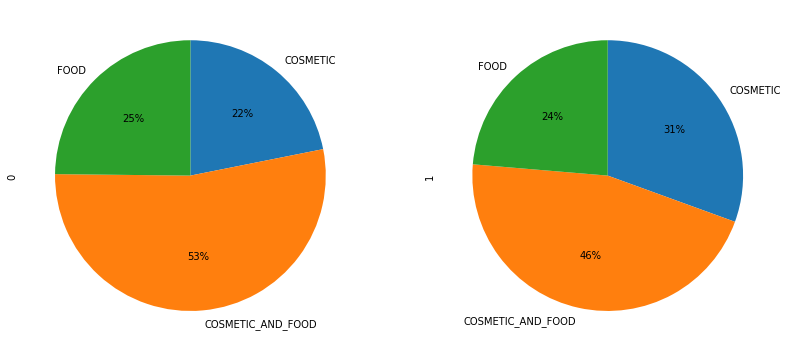

In [13]:
customers_df.groupby(['ONLINE_PURCHASE'])['PRODUCT_GROUP'].value_counts().unstack().plot.bar(figsize = [12, 5], rot=0).set_title('ONLINE_PURCHASE vs. PRODUCT_GROUP')

customers_df.groupby(['ONLINE_PURCHASE'])['PRODUCT_GROUP'].value_counts().unstack().T.plot.pie(subplots=True, autopct='%1.f%%', figsize=[12,5], legend=False, startangle = 90, counterclock = False)

plt.tight_layout()
plt.show()

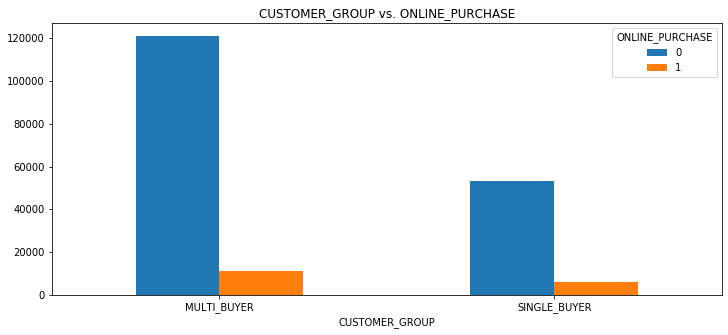

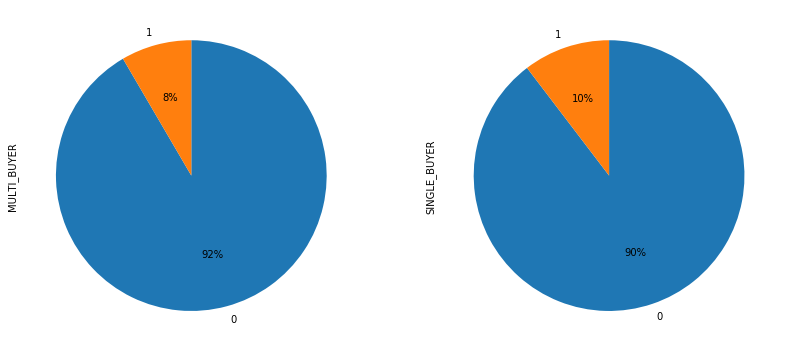

In [14]:
customers_df.groupby(['CUSTOMER_GROUP'])['ONLINE_PURCHASE'].value_counts().unstack().plot.bar(figsize = [12, 5], rot=0).set_title('CUSTOMER_GROUP vs. ONLINE_PURCHASE')

customers_df.groupby(['CUSTOMER_GROUP'])['ONLINE_PURCHASE'].value_counts().unstack().T.plot.pie(subplots=True, autopct='%1.f%%', figsize=[12,5], legend=False, startangle = 90, counterclock = False)

plt.tight_layout()
plt.show()

### Data Exploration - Attributes vs. Values

#### Load attributes dataset

In [15]:
# attributes dataset
attributes_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1, index_col=[1]).reset_index()
del attributes_df['Unnamed: 0']
attributes_df.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [16]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
Information level    312 non-null object
Attribute            313 non-null object
Description          313 non-null object
Additional notes     20 non-null object
dtypes: object(4)
memory usage: 9.9+ KB


#### Load values dataset

In [17]:
# values dataset
values_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, index_col=[1,2]).reset_index()
del values_df['Unnamed: 0']
values_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [18]:
values_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
Attribute      2258 non-null object
Description    2258 non-null object
Value          2258 non-null object
Meaning        2247 non-null object
dtypes: object(4)
memory usage: 70.6+ KB


In [19]:
# values_df only
np.setdiff1d(values_df.Attribute.unique(), attributes_df.Attribute)

array(['BIP_FLAG', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_LOTTO_RZ',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'KBA13_CCM_3000', 'KBA13_CCM_3001'], dtype=object)

In [20]:
# attributes_df only
np.setdiff1d(attributes_df.Attribute, values_df.Attribute.unique())

array(['ARBEIT', 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
       'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
       'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
       'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
       'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'],
      dtype=object)

From above, we can find attributes dataset features not normalized. We will use values dataset to query data, and merge attributes dataset feature to values.

Create `attr_only_attributes_not_values` to hold features only in `attributes_df` and not in `values_df`.

In [21]:
attr_only_attributes_not_values = np.array(['ARBEIT', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'])

creqte `annot_attribute` as combined features from `vlaues_df` and `attributes_df`.

In [22]:
annot_attribute = np.union1d(values_df.Attribute.unique(), attr_only_attributes_not_values)

In [23]:
annot_attribute.size

322

We found `only_attr_customers` not in `annot_attribute`

In [24]:
np.isin(only_attr_customers, values_df.Attribute)

array([False, False, False])

#### Analyze feature type

Fina all value of `values_df`

We create below variable to hold different type of features.

| variable                   | feature type     |
|----------------------------|------------------|
| `bin_cat_annot_attribute`  | binary categor   |
| `nom_cat_annot_attribute`  | nominal category |
| `ord_cat_annot_attribute`  | ordinal category |
| `mix_cat_annot_attribute`  | mix caztegory    |
| `num_annot_attribute`      | quantitative     |
| `unused_annot_attribute`   | unused           |

In [25]:
bin_cat_annot_attribute = np.array(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP'])

nom_cat_annot_attribute = np.array(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ',
       'ZABEOTYP', 'AGER_TYP', 'D19_KONSUMTYP', 'HEALTH_TYP'])

ord_cat_annot_attribute = np.array(['ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ARBEIT',
       'BALLRAUM', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12',
       'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'EWDICHTE', 'FINANZ_ANLEGER',
       'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GEBAEUDETYP_RASTER',
       'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1',
       'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2',
       'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU',
       'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3',
       'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP',
       'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2',
       'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER',
       'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2',
       'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST',
       'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2',
       'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MODTEMP',
       'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10',
       'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5',
       'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9',
       'KBA05_VORB0', 'KBA05_VORB1', 'KBA05_VORB2', 'KBA05_ZUL1',
       'KBA05_ZUL2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'KBA13_ALTERHALTER_30',
       'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60',
       'KBA13_ALTERHALTER_61', 'KBA13_AUDI', 'KBA13_AUTOQUOTE',
       'KBA13_BJ_1999', 'KBA13_BJ_2000', 'KBA13_BJ_2004', 'KBA13_BJ_2006',
       'KBA13_BJ_2008', 'KBA13_BJ_2009', 'KBA13_BMW', 'KBA13_CCM_0_1400',
       'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400',
       'KBA13_CCM_1500', 'KBA13_CCM_1600', 'KBA13_CCM_1800',
       'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_2501',
       'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FAB_ASIEN',
       'KBA13_FAB_SONSTIGE', 'KBA13_FIAT', 'KBA13_FORD',
       'KBA13_HALTER_20', 'KBA13_HALTER_25', 'KBA13_HALTER_30',
       'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45',
       'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60',
       'KBA13_HALTER_65', 'KBA13_HALTER_66', 'KBA13_HERST_ASIEN',
       'KBA13_HERST_AUDI_VW', 'KBA13_HERST_BMW_BENZ',
       'KBA13_HERST_EUROPA', 'KBA13_HERST_FORD_OPEL', 'KBA13_HERST_SONST',
       'KBA13_KMH_0_140', 'KBA13_KMH_110', 'KBA13_KMH_140',
       'KBA13_KMH_140_210', 'KBA13_KMH_180', 'KBA13_KMH_211',
       'KBA13_KMH_250', 'KBA13_KMH_251', 'KBA13_KRSAQUOT',
       'KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ',
       'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KRSSEG_KLEIN',
       'KBA13_KRSSEG_OBER', 'KBA13_KRSSEG_VAN', 'KBA13_KRSZUL_NEU',
       'KBA13_KW_0_60', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121',
       'KBA13_KW_30', 'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60',
       'KBA13_KW_61_120', 'KBA13_KW_70', 'KBA13_KW_80', 'KBA13_KW_90',
       'KBA13_MAZDA', 'KBA13_MERCEDES', 'KBA13_MOTOR', 'KBA13_NISSAN',
       'KBA13_OPEL', 'KBA13_PEUGEOT', 'KBA13_RENAULT',
       'KBA13_SEG_GELAENDEWAGEN', 'KBA13_SEG_GROSSRAUMVANS',
       'KBA13_SEG_KLEINST', 'KBA13_SEG_KLEINWAGEN',
       'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_SEG_MINIVANS',
       'KBA13_SEG_MINIWAGEN', 'KBA13_SEG_MITTELKLASSE',
       'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_SEG_OBERKLASSE',
       'KBA13_SEG_SONSTIGE', 'KBA13_SEG_SPORTWAGEN',
       'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN', 'KBA13_SEG_WOHNMOBILE',
       'KBA13_SITZE_4', 'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA',
       'KBA13_VORB_0', 'KBA13_VORB_1', 'KBA13_VORB_1_2', 'KBA13_VORB_2',
       'KBA13_VORB_3', 'KBA13_VW', 'KKK', 'KONSUMNAEHE', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'ORTSGR_KLS9',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4',
       'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'REGIOTYP', 'RELAT_AB',
       'RETOURTYP_BK_S', 'SEMIO_DOM', 'SEMIO_ERL', 'SEMIO_FAM',
       'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST',
       'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL',
       'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT', 'WOHNDAUER_2008',
       'W_KEIT_KIND_HH'])

mix_cat_annot_attribute = np.array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'])

num_annot_attribute = np.array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'])

In [26]:
num_annot_attribute.size + bin_cat_annot_attribute.size + nom_cat_annot_attribute.size + ord_cat_annot_attribute.size + mix_cat_annot_attribute.size

276

In [27]:
unused_annot_attribute = np.setdiff1d(annot_attribute, np.union1d(np.union1d(np.union1d(np.union1d(num_annot_attribute, bin_cat_annot_attribute), nom_cat_annot_attribute), ord_cat_annot_attribute), mix_cat_annot_attribute))

In [28]:
assert annot_attribute.size == num_annot_attribute.size + bin_cat_annot_attribute.size + nom_cat_annot_attribute.size + ord_cat_annot_attribute.size + mix_cat_annot_attribute.size + unused_annot_attribute.size

#### Analyze unknown value

list all possible unknown meaning string

In [29]:
values_df.loc[np.where(values_df.Meaning.str.contains('know'))].Meaning.unique()

array(['unknown', 'unknown / no main age detectable',
       'no transactions known', 'no transaction known',
       'residental building buildings without actually known household',
       'mixed building without actually known household or comapny ',
       'company building w/o known company ',
       'mixed building without actually known household ',
       'mixed building without actually known company ', nan],
      dtype=object)

We create below variable to hold different type of unknow value dataframe.

| variable                         | meaning                          |
|----------------------------------|----------------------------------|
| `unknown_values_df`              | unknown                          |
| `main_age_unknown_values_df`     | unknown / no main age detectable |
| `transactions_unknown_values_df` | no transactions know             |
| `transaction_unknown_values_df`  | no transaction known             |

In [30]:
unknown_values_df = values_df[values_df.Meaning == 'unknown']
main_age_unknown_values_df = values_df[values_df.Meaning == 'unknown / no main age detectable']
transactions_unknown_values_df = values_df[values_df.Meaning == 'no transactions known']
transaction_unknown_values_df = values_df[values_df.Meaning == 'no transaction known']

### Data Exploration - customers vs. values

#### COLUMN Veiewpoint

We create below variable to hold common features of `customers_df` and `annot_atribute`.

| variable                          |                                                          |
|-----------------------------------|----------------------------------------------------------|
| `annot_attr_customers_values`     | common features of `customer_df` and `annot_attribute`   |
| `not_annot_attr_customers_values` | distinct features of `customer_df` and `annot_attribute` |

In [31]:
annot_attr_customers_values = np.intersect1d(customers_df.columns.values, annot_attribute)
not_annot_attr_customers_values = np.setdiff1d(customers_df.columns.values, annot_attr_customers_values)

In [32]:
assert customers_df.columns.values.size == annot_attr_customers_values.size + not_annot_attr_customers_values.size

In [33]:
customers_df[annot_attr_customers_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 276 entries, AGER_TYP to ZABEOTYP
dtypes: float64(216), int64(57), object(3)
memory usage: 403.6+ MB


#### Check missing value

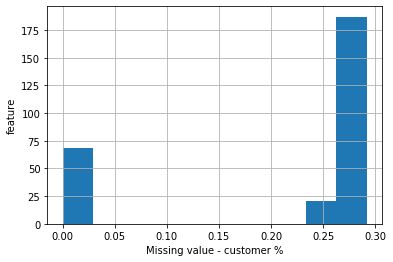

In [34]:
customers_df[annot_attr_customers_values].isnull().mean().hist()
plt.xlabel('Missing value - customer %')
plt.ylabel('feature')
plt.show()

We can find all customers have missing value among documented features are less than 30%.

CUSTOMER DROP CRITERIA: __missing value customers % > 30%__

In [35]:
FEATURE_DROP_RATIO=.3

We create below variable to hold diffent type of feature in `customers_df`

| variable                            |                                                  |
|-------------------------------------|--------------------------------------------------|
| `customers_bin_cat_annot_attribute` | hold `bin_cat_annot_attribute` in `values_df`    |
| `customers_nom_cat_annot_attribute` | hold `nom_cat_annot_attribute` in `values_df`    |
| `customers_ord_cat_annot_attribute` | hold `ord_cat_annot_attribute` in `values_df`    |
| `customers_mix_cat_annot_attribute` | hold `mix_cat_annot_attribute` in `values_df`    |
| `customers_num_annot_attribute`     | hold `num_annot_attribute` in `values_df`        |
| `customers_unused_annot_attribute`  | hold unused features in `values_df`              |

In [36]:
customers_unused_annot_attribute = annot_attr_customers_values[customers_df[annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO]

In [37]:
customers_unused_annot_attribute.size

0

#### Check `customers_bin_cat_annot_attribute`

In [38]:
customers_bin_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, bin_cat_annot_attribute)
customers_bin_cat_annot_attribute = np.setdiff1d(customers_bin_cat_annot_attribute, customers_unused_annot_attribute)

In [39]:
customers_bin_cat_annot_attribute

array(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP'],
      dtype=object)

In [40]:
for col in customers_bin_cat_annot_attribute:
    v1 = customers_df[col].dropna().unique()
    if col == 'OST_WEST_KZ':
        v2 = values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: np.nan if x == -1 else x).dropna().values
    else:
        v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: x if not isinstance(x, str) else x.split(','))).astype(int)
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

#### Check `customers_nom_cat_annot_attribute`

In [41]:
customers_nom_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, nom_cat_annot_attribute)
customers_nom_cat_annot_attribute = np.setdiff1d(customers_nom_cat_annot_attribute, customers_unused_annot_attribute)

In [42]:
customers_nom_cat_annot_attribute

array(['AGER_TYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP',
       'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP',
       'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'ZABEOTYP'],
      dtype=object)

In [43]:
for col in customers_nom_cat_annot_attribute:
    
    unknown_v = []
    if col == 'CAMEO_DEUG_2015':
        v1 = customers_df[col].dropna().apply(lambda x: unknown_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
    else:
        v1 = customers_df[col].dropna().unique()

    if col == 'CAMEO_DEUG_2015' or col == 'CAMEO_DEU_2015':
        v2 = values_df[values_df.Attribute == col]['Value'].values
    else:
        v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: x if not isinstance(x, str) else x.split(','))).astype(int)
    
    v = np.setdiff1d(v1, v2)
    unknown_v = np.unique(np.array(unknown_v))
    
    if len(unknown_v) > 0:
        print('{} feature has unknown value: {}'.format(col, unknown_v))
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

CAMEO_DEUG_2015 feature has unknown value: ['1' '2' '3' '4' '5' '6' '7' '8' '9' 'X']
CAMEO_DEU_2015 feature has undocumented value: ['XX']
LP_FAMILIE_FEIN feature has undocumented value: [0.]
LP_FAMILIE_GROB feature has undocumented value: [0.]


#### Check `ord_cat_annot_attribute`

In [44]:
customers_ord_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, ord_cat_annot_attribute)
customers_ord_cat_annot_attribute = np.setdiff1d(customers_ord_cat_annot_attribute, customers_unused_annot_attribute)

In [45]:
customers_ord_cat_annot_attribute.size

246

In [46]:
for col in customers_ord_cat_annot_attribute:

    unknown_v = []
    v1 = customers_df[col].dropna().apply(lambda x: unknown_v.append(x) if isinstance(x, str) else x).dropna().unique()

    # assue value of 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM' are as same as 'D19_BANKEN_DATUM'
    if col in ['D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM']:
        col = 'D19_BANKEN_DATUM'
    
    if values_df[values_df.Attribute == col].shape[0] > 0:
        v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
    else:
        v2 = np.array([])

    v = np.setdiff1d(v1, v2)
    unknown_v = np.unique(np.array(unknown_v))
    
    if len(unknown_v) > 0:
        print('{} feature has unknown value: {}'.format(col, unknown_v))
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

ARBEIT feature has undocumented value: [1. 2. 3. 4. 5. 9.]
KBA05_MODTEMP feature has undocumented value: [6.]


#### Check `customers_mix_cat_annot_attribute`

In [47]:
customers_mix_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, mix_cat_annot_attribute)
customers_mix_cat_annot_attribute = np.setdiff1d(customers_mix_cat_annot_attribute, customers_unused_annot_attribute)

In [48]:
customers_mix_cat_annot_attribute

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'], dtype=object)

In [49]:
for col in customers_mix_cat_annot_attribute:
    v1 = customers_df[col].dropna().unique()
    v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: x if not isinstance(x, str) else x.split(','))).astype(int)
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

LP_LEBENSPHASE_FEIN feature has undocumented value: [0.]
LP_LEBENSPHASE_GROB feature has undocumented value: [0.]


#### Check `num_annot_attribute`

In [50]:
customers_num_annot_attribute = np.intersect1d(annot_attr_customers_values, num_annot_attribute)
customers_num_annot_attribute = np.setdiff1d(customers_num_annot_attribute, customers_unused_annot_attribute)

In [51]:
customers_num_annot_attribute

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'],
      dtype=object)

In [52]:
for col in customers_num_annot_attribute:
    if not np.issubdtype(customers_df[col].dtype, np.number):
        print('{} is not numberic type'.format(col))

#### To fix the error, we will need to ...

1. CAMEO_DEUG_2015: **change '1', '2', '3', '4', '5', '6', '7', '8', '9' to integer, and 'X' to NA**
1. CAMEO_DEU_2015: **change 'XX' to NA**
1. KBA05_MODTEMP: **change 6 to NA**
1. LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB: **chagne 0 to NA**
1. All other attributes: **convert to integer**

In [53]:
assert annot_attr_customers_values.size == customers_bin_cat_annot_attribute.size \
                                            + customers_nom_cat_annot_attribute.size \
                                            + customers_ord_cat_annot_attribute.size \
                                            + customers_mix_cat_annot_attribute.size \
                                            + customers_num_annot_attribute.size \
                                            + customers_unused_annot_attribute.size

#### Check unknown value

We create below variable to hold diffent type of feature in unknown feature in `customers_df`

| variable                                |                                                                           |
|-----------------------------------------|---------------------------------------------------------------------------|
| `customers_unknown_values_df`              | hold 'unknown' meaning feature in `customers_df`                          |
| `customers_main_age_unknown_values_df`     | hold 'unknown / no main age detectable' meaning feature in `customers_df` |
| `customers_transactions_unknown_values_df` | hold 'no transactions known' meaning feature in `customers_df`            |
| `customers_transaction_unknown_values_df`  | hold 'no transaction known' meaning feature in `customers_df`             |

In [54]:
customers_unknown_values_df = unknown_values_df[np.isin(unknown_values_df.Attribute, np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_main_age_unknown_values_df = main_age_unknown_values_df[np.isin(main_age_unknown_values_df.Attribute, np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_transactions_unknown_values_df = transactions_unknown_values_df[np.isin(transactions_unknown_values_df.Attribute, np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_transaction_unknown_values_df = transaction_unknown_values_df[np.isin(transaction_unknown_values_df.Attribute.str[:-3], np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_transaction_unknown_values_df.Attribute = customers_transaction_unknown_values_df.Attribute.str[:-3]

/Users/fc/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


##### check `not_annot_attr_customers_values`

In [55]:
customers_df[not_annot_attr_customers_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 93 columns):
AKT_DAT_KL                    145056 non-null float64
ALTERSKATEGORIE_FEIN          139810 non-null float64
ALTER_KIND1                   11766 non-null float64
ALTER_KIND2                   5100 non-null float64
ALTER_KIND3                   1275 non-null float64
ALTER_KIND4                   236 non-null float64
ANZ_KINDER                    145056 non-null float64
ANZ_STATISTISCHE_HAUSHALTE    141725 non-null float64
CAMEO_INTL_2015               141224 non-null object
CJT_KATALOGNUTZER             188439 non-null float64
CJT_TYP_1                     188439 non-null float64
CJT_TYP_2                     188439 non-null float64
CJT_TYP_3                     188439 non-null float64
CJT_TYP_4                     188439 non-null float64
CJT_TYP_5                     188439 non-null float64
CJT_TYP_6                     188439 non-null float64
CUSTOMER_GROUP                1916

We create below variable to hold differennt type of undocumented features in `customers_df`.

| variable                                |                                                      |
|-----------------------------------------|------------------------------------------------------|
| `customers_bin_cat_not_annot_attribute` | hold binary category feature in `customers_df`       |
| `customers_nom_cat_not_annot_attribute` | hold nominal category feature in `customers_df`      |
| `customers_ord_cat_not_annot_attribute` | hold ordinal categroy feature in `customers_df`      |
| `customers_mix_cat_not_annot_attribute` | hold mix category feature in `customers_df`          |
| `customers_num_not_annot_attribute`     | hold quantative feature in `customers_df`            |
| `customers_unused_not_annot_attribute`  | hold unused features in `customers_df`               |

In [56]:
customers_bin_cat_not_annot_attribute = np.array(['DSL_FLAG', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'SOHO_KZ'])

customers_nom_cat_not_annot_attribute = np.array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'EXTSEL992',
       'GEMEINDETYP', 'VERDICHTUNGSRAUM', 'VK_DHT4A'])

customers_ord_cat_not_annot_attribute = np.array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'CJT_KATALOGNUTZER',
       'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5',
       'CJT_TYP_6', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO',
       'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL',
       'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK',
       'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX',
       'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES',
       'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12',
       'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_REST',
       'D19_VERSICHERUNGEN', 'D19_VERSI_ONLINE_QUOTE_12',
       'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'EINGEZOGENAM_HH_JAHR',
       'FIRMENDICHTE', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3',
       'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_GBZ',
       'KBA13_HHZ', 'KBA13_KMH_210', 'KK_KUNDENTYP', 'KOMBIALTER', 'LNR',
       'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',
       'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG',
       'UNGLEICHENN_FLAG', 'VHA', 'VHN', 'VK_DISTANZ', 'VK_ZG11', 'ANZ_KINDER'])

customers_mix_cat_not_annot_attribute = np.array(['CAMEO_INTL_2015'])

customers_num_not_annot_attribute = np.array(['ANZ_STATISTISCHE_HAUSHALTE'])

customers_unused_not_annot_attribute = only_attr_customers

In [57]:
assert not_annot_attr_customers_values.size == customers_bin_cat_not_annot_attribute.size \
                                                + customers_nom_cat_not_annot_attribute.size \
                                                + customers_ord_cat_not_annot_attribute.size \
                                                + customers_mix_cat_not_annot_attribute.size \
                                                + customers_num_not_annot_attribute.size \
                                                + customers_unused_not_annot_attribute.size

#### Check missing value

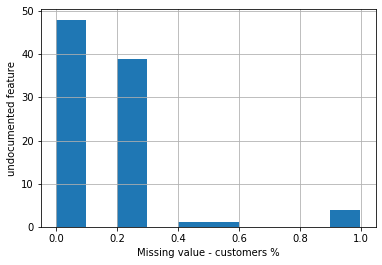

In [58]:
customers_df[not_annot_attr_customers_values].isnull().mean().hist()
plt.xlabel('Missing value - customers %')
plt.ylabel('undocumented feature')
plt.show()

We can find over 30% csutomers still have missing value among about 6 undocumented features.

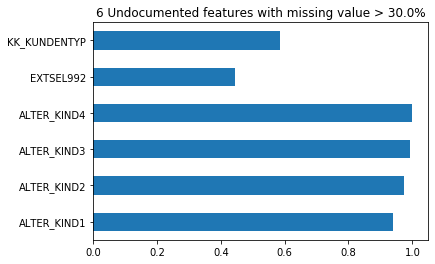

In [59]:
_ = not_annot_attr_customers_values[customers_df[not_annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO]
customers_df[_].isnull().mean().plot.barh()
plt.title('{} Undocumented features with missing value > {}%'.format(_.size, FEATURE_DROP_RATIO*100))
plt.show()

In [60]:
customers_unused_not_annot_attribute = np.union1d(customers_unused_not_annot_attribute, not_annot_attr_customers_values[customers_df[not_annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO])

In [61]:
customers_unused_not_annot_attribute

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'CUSTOMER_GROUP', 'EXTSEL992', 'KK_KUNDENTYP', 'ONLINE_PURCHASE',
       'PRODUCT_GROUP'], dtype=object)

#### Ananlyze EINGEFUEGT_AM

convert datetime string to unix second integer

In [62]:
pd.to_datetime(customers_df['EINGEFUEGT_AM']).describe()

count                  141725
unique                   3034
top       1992-02-10 00:00:00
freq                    64744
first     1992-02-10 00:00:00
last      2016-07-05 00:00:00
Name: EINGEFUEGT_AM, dtype: object

__NOTE__: We will convert datetime string to year based categorical feature

#### Analyze D19_LETZTER_KAUF_BRANCHE

convert string to column index

In [63]:
customers_df['D19_LETZTER_KAUF_BRANCHE'].describe()

count            143955
unique               35
top       D19_UNBEKANNT
freq              31910
Name: D19_LETZTER_KAUF_BRANCHE, dtype: object

In [64]:
customers_df[customers_df['D19_LETZTER_KAUF_BRANCHE'].notna()]['D19_LETZTER_KAUF_BRANCHE'].apply(lambda x: np.where(customers_df.columns == x)[0][0] if x != 'D19_UNBEKANNT' else 0).unique()

array([ 0, 32, 63, 67, 42, 44, 68, 70, 93, 74, 94, 55, 45, 65, 33, 86, 39,
       46, 38, 78, 66, 31, 56, 37, 60, 47, 54, 64, 43, 41, 40, 95, 79, 62,
       59])

__NOTE__: We will change feature string to column index.

#### Analyze CAMEO_INTL_2015

In [65]:
int_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: int_v.append(x) if isinstance(x, int) else x).dropna().unique()

float_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: float_v.append(x) if isinstance(x, float) else x).dropna().unique()

str_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: str_v.append(x) if isinstance(x, str) else x).dropna().unique()

int_v = np.unique(np.array(int_v))
float_v = np.unique(np.array(float_v))
str_v = np.unique(np.array(str_v))

if len(int_v) > 0:
    print('CAMEO_INTL_2015 feature has int value: {}'.format(int_v))
if len(float_v) > 0:
    print('CAMEO_INTL_2015 feature has float value: {}'.format(float_v))
if len(str_v) > 0:
    print('CAMEO_INTL_2015 feature has string value: {}'.format(str_v))

CAMEO_INTL_2015 feature has float value: [12. 13. 14. 15. 22. 23. 24. 25. 31. 32. 33. 34. 35. 41. 43. 44. 45. 51.
 52. 54. 55.]
CAMEO_INTL_2015 feature has string value: ['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55' 'XX']


__NOTE__: CAMEO_INTL_2015 combines information on two axes: wealth and life stage. I will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.

LNR is like serial number

In [66]:
customers_df.shape[0] == customers_df['LNR'].unique().size

True

In [67]:
customers_unused_not_annot_attribute = np.union1d(customers_unused_not_annot_attribute, 'LNR')
customers_ord_cat_not_annot_attribute = np.setdiff1d(customers_ord_cat_not_annot_attribute, 'LNR')

#### To fix the error, we will need to ...

1. ONLINE_PURCHASE, CUSTOMER_GROUP, PRODUCT_GROUP: **drop (not exist in general population)**
1. ALTER_KIND1, ALTER_KIND2, ALTER_KIND3, ALTER_KIND4, EXTSEL992, KK_KUNDENTYP: **drop (missing value > 30%)**
1. EINGEFUEGT_AM: **convert datetime string to year based categorical feature**
1. D19_LETZTER_KAUF_BRANCHE: **change feature string to column index**
1. CAMEO_INTL_2015: **change '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35', '23', '12', '44', '41', '52', '31', '13', '34', '32', '33' to integer, and 'XX' to NA. Combines information on two axes: wealth and life stage. I will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.**
1. LNR: **drop (like serial number)**
1. All other attribute: **convert to integer**

In [68]:
customers_bin_cat_not_annot_attribute = np.setdiff1d(customers_bin_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_nom_cat_not_annot_attribute = np.setdiff1d(customers_nom_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_ord_cat_not_annot_attribute = np.setdiff1d(customers_ord_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_mix_cat_not_annot_attribute = np.setdiff1d(customers_mix_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_num_not_annot_attribute = np.setdiff1d(customers_num_not_annot_attribute, customers_unused_not_annot_attribute)

In [69]:
assert not_annot_attr_customers_values.size == customers_bin_cat_not_annot_attribute.size \
                                                + customers_nom_cat_not_annot_attribute.size \
                                                + customers_ord_cat_not_annot_attribute.size \
                                                + customers_mix_cat_not_annot_attribute.size \
                                                + customers_num_not_annot_attribute.size \
                                                + customers_unused_not_annot_attribute.size

In [70]:
customers_unused_not_annot_attribute

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'CUSTOMER_GROUP', 'EXTSEL992', 'KK_KUNDENTYP', 'LNR',
       'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype=object)

#### ROW Viewpoint

#### Check missing value

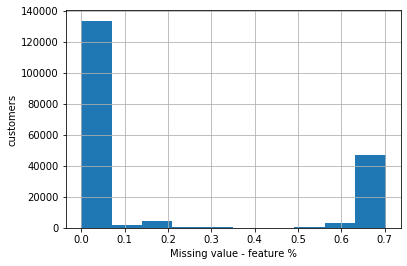

In [71]:
customers_df.isnull().mean(axis=1).hist()
plt.xlabel('Missing value - feature %')
plt.ylabel('customers')
plt.show()

Around 50000 customers (26.76%) have missing value over 30% feature.

In [72]:
CUSTOMER_DROP_RATIO = .3

customers_df[customers_df.isnull().mean(axis=1) > CUSTOMER_DROP_RATIO].shape[0]/customers_df.shape[0]

0.2675735186692547

#### To fix the error, we will need to ...

1. Drop customers with **missing value feature % > 30%**

### Data Exploration - azdias vs. customers

In [73]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


#### Check missing value

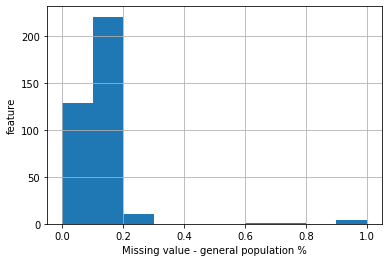

In [74]:
azdias_df.isnull().mean().hist()
plt.xlabel('Missing value - general population %')
plt.ylabel('feature')
plt.show()

Over 30% general population have around 10 feature have missing value.


We create below variable to hold differennt type of documented features in general population.

| variable                         |                                                                |
|----------------------------------|----------------------------------------------------------------|
| `annot_attr_azdias_values`       | to hold below all documented features in general population    |
| `azdias_bin_cat_annot_attribute` | hold `customers_bin_cat_annot_attribute` in general population |
| `azdias_nom_cat_annot_attribute` | hold `customers_nom_cat_annot_attribute` in general population |
| `azdias_ord_cat_annot_attribute` | hold `customers_ord_cat_annot_attribute` in general population |
| `azdias_mix_cat_annot_attribute` | hold `customers_mix_cat_annot_attribute` in general population |
| `azdias_num_annot_attribute`     | hold `customers_num_annot_attribute` in general population     |
| `azdias_unused_annot_attribute`  | hold `customers_unused_annot_attribute` in general population  |

We create below variable to hold differennt type of undocumented features in general population.

| variable                             |                                                                    |
|--------------------------------------|--------------------------------------------------------------------|
| `not_annot_attr_azdias_values`       | hold below all undocumented features in general population         |
| `azdias_bin_cat_not_annot_attribute` | hold `customers_bin_cat_not_annot_attribute` in general population |
| `azdias_nom_cat_not_annot_attribute` | hold `customers_nom_cat_not_annot_attribute` in general population |
| `azdias_ord_cat_not_annot_attribute` | hold `customers_ord_cat_not_annot_attribute` in general population |
| `azdias_mix_cat_not_annot_attribute` | hold `customers_mix_cat_not_annot_attribute` in general population |
| `azdias_num_not_annot_attribute`     | hold `customers_num_not_annot_attribute` in general population     |
| `azdias_unused_not_annot_attribute`  | hold `customers_unused_not_annot_attribute` in general population  |

In [75]:
annot_attr_azdias_values = annot_attr_customers_values
not_annot_attr_azdias_values = np.setdiff1d(not_annot_attr_customers_values, only_attr_customers)

In [76]:
assert annot_attr_azdias_values.size + not_annot_attr_azdias_values.size == customers_df.columns.size - only_attr_customers.size

In [77]:
azdias_unused_annot_attribute = np.intersect1d(azdias_df.columns[azdias_df.isnull().mean() > FEATURE_DROP_RATIO].values, annot_attr_azdias_values)
azdias_unused_annot_attribute = np.union1d(azdias_unused_annot_attribute, customers_unused_annot_attribute)
azdias_bin_cat_annot_attribute = np.setdiff1d(customers_bin_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_nom_cat_annot_attribute = np.setdiff1d(customers_nom_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_ord_cat_annot_attribute = np.setdiff1d(customers_ord_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_mix_cat_annot_attribute = np.setdiff1d(customers_mix_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_num_annot_attribute = np.setdiff1d(customers_num_annot_attribute, azdias_unused_annot_attribute)
azdias_unused_annot_attribute

array([], dtype=object)

In [78]:
assert annot_attr_azdias_values.size == azdias_bin_cat_annot_attribute.size \
                                        + azdias_nom_cat_annot_attribute.size \
                                        + azdias_ord_cat_annot_attribute.size \
                                        + azdias_mix_cat_annot_attribute.size \
                                        + azdias_num_annot_attribute.size \
                                        + azdias_unused_annot_attribute.size

In [79]:
azdias_unused_not_annot_attribute = np.intersect1d(azdias_df.columns[azdias_df.isnull().mean() > FEATURE_DROP_RATIO].values, not_annot_attr_azdias_values)
azdias_unused_not_annot_attribute = np.union1d(azdias_unused_not_annot_attribute, customers_unused_not_annot_attribute)
azdias_unused_not_annot_attribute = np.setdiff1d(azdias_unused_not_annot_attribute, only_attr_customers)
azdias_bin_cat_not_annot_attribute = np.setdiff1d(customers_bin_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_nom_cat_not_annot_attribute = np.setdiff1d(customers_nom_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_ord_cat_not_annot_attribute = np.setdiff1d(customers_ord_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_mix_cat_not_annot_attribute = np.setdiff1d(customers_mix_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_num_not_annot_attribute = np.setdiff1d(customers_num_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_unused_not_annot_attribute

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'KK_KUNDENTYP', 'LNR'], dtype=object)

In [80]:
assert not_annot_attr_azdias_values.size == azdias_bin_cat_not_annot_attribute.size \
                                            + azdias_nom_cat_not_annot_attribute.size \
                                            + azdias_ord_cat_not_annot_attribute.size \
                                            + azdias_mix_cat_not_annot_attribute.size \
                                            + azdias_num_not_annot_attribute.size \
                                            + azdias_unused_not_annot_attribute.size

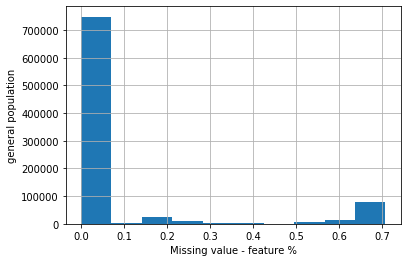

In [81]:
azdias_df.isnull().mean(axis=1).hist()
plt.xlabel('Missing value - feature %')
plt.ylabel('general population')
plt.show()

Around 100000 (11.87%) general population have missing value over 30% feature.

In [82]:
azdias_df[azdias_df.isnull().mean(axis=1) > CUSTOMER_DROP_RATIO].shape[0]/azdias_df.shape[0]

0.11871915046885116

We need to **check general population value is matched with customers**.

#### Ananlyze `azdias_bin_cat_annot_attribute`

Every category should exist in general population.

In [83]:
for col in azdias_bin_cat_annot_attribute:
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))  

#### Ananlyze `azdias_nom_cat_annot_attribute`

Every category should exist in general population.

In [84]:
for col in azdias_nom_cat_annot_attribute:

    str_azdias_v = []
    str_customers_v = []
    
    if col == 'CAMEO_DEUG_2015':
        
        azdias_v = azdias_df[col].dropna().apply(lambda x: str_azdias_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        customers_v = customers_df[col].dropna().apply(lambda x: str_customers_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        diff_str_azdias_v = np.setdiff1d(str_azdias_v, str_customers_v)
        diff_str_customers_v = np.setdiff1d(str_customers_v, str_azdias_v)
        str_azdias_v = np.unique(str_azdias_v)
        str_customers_v = np.unique(str_customers_v)
        str_azdias_v = []
        str_customers_v = []
    else:
        
        azdias_v = azdias_df[col].dropna().unique()
        customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        
        true_v =  np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
        diff_diff_azdias_v = np.setdiff1d(diff_azdias_v, true_v)
        if diff_diff_azdias_v.size > 0:
            print('{} only in gnneral population : {} <- undocumented'.format(col, diff_diff_azdias_v))
        else:
            print('{} only in gnneral population : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customer : {}'.format(col, diff_customers_v))
    if len(str_azdias_v) > 0:
        print('{} only in general population : {}'.format(col, diff_str_azdias_v))
    if len(str_customers_v) > 0:
        print('{} only in customer : {}'.format(col, diff_str_customers_v))

GEBAEUDETYP only in gnneral population : [5.]
TITEL_KZ only in gnneral population : [2.]


#### Ananlyze `azdias_ord_cat_annot_attribute`

Every category should exist in general population.

In [85]:
for col in azdias_ord_cat_annot_attribute:
    
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        
        true_v =  np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
        diff_diff_azdias_v = np.setdiff1d(diff_azdias_v, true_v)
        if diff_diff_azdias_v.size > 0:
            print('{} only in gnneral population : {} <- undocumented'.format(col, diff_diff_azdias_v))
        else:
            print('{} only in gnneral population : {}'.format(col, diff_azdias_v))
    
    if diff_customers_v.size > 0:
        print('{} only in customer : {}'.format(col, diff_customers_v))

ALTER_HH only in gnneral population : [1.]
D19_BANKEN_ONLINE_QUOTE_12 only in gnneral population : [1.]
KBA05_GBZ only in customer : [0.]
KBA13_AUTOQUOTE only in gnneral population : [0.]
KBA13_KRSAQUOT only in gnneral population : [0.]
KBA13_KRSHERST_AUDI_VW only in gnneral population : [0.]
KBA13_KRSHERST_BMW_BENZ only in gnneral population : [0.]
KBA13_KRSHERST_FORD_OPEL only in gnneral population : [0.]
KBA13_KRSSEG_KLEIN only in gnneral population : [0.]
ORTSGR_KLS9 only in gnneral population : [0.] <- undocumented


__NOTE__: According to KBA05_GBZ, We need to drop below 2 customers, because 0 only exist int customer.

In [86]:
customers_df[customers_df['KBA05_GBZ'] == 0]

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
57257,164783,2,1.0,5.0,NaN,NaN,NaN,NaN,5.0,79.0,...,3.0,NaN,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
169196,101306,2,9.0,10.0,NaN,NaN,NaN,NaN,10.0,79.0,...,4.0,6.0,8.0,2.0,3,FOOD,SINGLE_BUYER,0,2,4


In [87]:
customers_outlier = np.array([164783, 101306])

#### Ananlyze `azdias_mix_cat_annot_attribute`

Every category should exist in general population.

In [88]:
for col in azdias_mix_cat_annot_attribute:
    
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))

#### Ananlyze `azdias_num_annot_attribute`

Gnneral population range should cover customer.

In [89]:
for col in azdias_num_annot_attribute:

    min_v1 = azdias_df[col].min()
    max_v1 = azdias_df[col].max()
    min_v2 = customers_df[col].min()
    max_v2 = customers_df[col].max()
    
    if min_v1 > min_v2:
        print('{} in azdias have min value: {} larger than customer: {}'.format(col, min_v1, min_v2))
    if max_v1 < max_v2:
        print('{} in azdias have max value: {} smaller than customer: {}'.format(col, min_v1, min_v2))

#### Ananlyze `azdias_bin_cat_not_annot_attribute`

Every category should exist in general population.

In [90]:
for col in azdias_bin_cat_not_annot_attribute:
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))  

#### Ananlyze `azdias_nom_cat_not_annot_attribute`

Every category should exist in general population.

In [91]:
for col in azdias_nom_cat_not_annot_attribute:
        
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))

EINGEFUEGT_AM different only in azdias : ['1991-06-17 00:00:00' '1991-08-30 00:00:00' '1992-12-17 00:00:00' ...
 '2016-04-20 00:00:00' '2016-05-02 00:00:00' '2016-05-09 00:00:00']
EINGEFUEGT_AM different only in customers_df : ['1993-04-29 00:00:00' '1993-06-02 00:00:00' '1994-09-29 00:00:00'
 '1997-09-15 00:00:00' '1997-12-12 00:00:00' '1998-11-07 00:00:00'
 '1998-11-13 00:00:00' '1999-02-19 00:00:00' '1999-03-16 00:00:00'
 '1999-08-16 00:00:00' '1999-10-25 00:00:00' '2000-12-01 00:00:00'
 '2001-01-02 00:00:00' '2001-01-17 00:00:00' '2001-01-18 00:00:00'
 '2001-03-14 00:00:00' '2001-12-04 00:00:00' '2002-04-26 00:00:00'
 '2003-01-20 00:00:00' '2003-06-28 00:00:00' '2003-12-06 00:00:00'
 '2004-06-12 00:00:00' '2005-05-28 00:00:00' '2005-08-08 00:00:00'
 '2005-10-06 00:00:00' '2006-06-09 00:00:00' '2006-07-01 00:00:00'
 '2006-07-16 00:00:00' '2006-11-10 00:00:00' '2006-12-17 00:00:00'
 '2006-12-23 00:00:00' '2007-03-20 00:00:00' '2007-03-25 00:00:00'
 '2007-03-28 00:00:00' '2007-05-03 0

#### Ananlyze `azdias_ord_cat_not_annot_attribute`

Every category should exist in general population.

In [92]:
for col in azdias_ord_cat_not_annot_attribute:
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()

    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:

        print('{} only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        
        print('{} only in customers_df : {}'.format(col, diff_customers_v))

ALTERSKATEGORIE_FEIN only in azdias : [1.]
ANZ_KINDER only in azdias : [ 9. 11.]
D19_TELKO_ONLINE_QUOTE_12 only in azdias : [7.]
D19_VERSI_ONLINE_QUOTE_12 only in azdias : [3. 6. 8. 9.]
EINGEZOGENAM_HH_JAHR only in azdias : [1900. 1904. 1971. 1984.]


#### Ananlyze `azdias_mix_cat_not_annot_attribute`

Every category should exist in general population.

In [93]:
for col in azdias_mix_cat_not_annot_attribute:
    
    str_azdias_v = []
    str_customers_v = []
    
    if col == 'CAMEO_INTL_2015':
        
        azdias_v = azdias_df[col].dropna().apply(lambda x: str_azdias_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        customers_v = customers_df[col].dropna().apply(lambda x: str_customers_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        diff_str_azdias_v = np.setdiff1d(str_azdias_v, str_customers_v)
        diff_str_customers_v = np.setdiff1d(str_customers_v, str_azdias_v)
        str_azdias_v = np.unique(str_azdias_v)
        str_customers_v = np.unique(str_customers_v)
        str_azdias_v = []
        str_customers_v = []
    else:
        
        azdias_v = azdias_df[col].dropna().unique()
        customers_v = customers_df[col].dropna().unique()
    
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))
    if len(str_azdias_v) > 0:
        print('{} different only in azdias : {}'.format(attr, diff_str_azdias_v))
    if len(str_customers_v) > 0:
        print('{} different only in customers : {}'.format(attr, diff_str_customers_v))

#### Ananlyze `azdias_num_not_annot_attribute`

Gnneral population range should cover customer.

In [94]:
for col in azdias_num_not_annot_attribute:

    min_v1 = azdias_df[col].min()
    max_v1 = azdias_df[col].max()
    min_v2 = customers_df[col].min()
    max_v2 = customers_df[col].max()
    
    if min_v1 > min_v2:
        print('{} in azdias have min value: {} larger than customer: {}'.format(col, min_v1, min_v2))
    if max_v1 < max_v2:
        print('{} in azdias have max value: {} smaller than customer: {}'.format(col, min_v1, min_v2))

#### To fix the error, we will need to ...

1. ORTSGR_KLS9: **change 0 to NA (undocumented in values_df)**
2. LNR(164783, 101306): **drop customer (KBA05_GBZ value 0 only in customer**

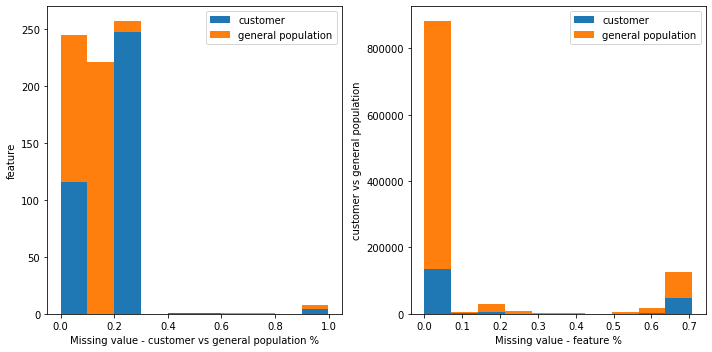

In [95]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((customers_df.isnull().mean(), azdias_df.isnull().mean()), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - customer vs general population %')
plt.ylabel('feature')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((customers_df.isnull().mean(axis=1), azdias_df.isnull().mean(axis=1)), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - feature %')
plt.ylabel('customer vs general population')
plt.legend()

plt.tight_layout()
plt.show()

### Data Preprocessing

#### What we want to do here ...

* `unknown2nd`: Convert all unknown value to NA.
* `formatit`: Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
* Analyze categorical and quantitative feature.
* `drop`: Drop customers and unused features.
* `cover`: Scan feature coverage with general population and customer.
* `fillna`: Fill every NA field a value. Categorical feature: max, Quantitative feature: median
* `onehot`: Apply one-hot encoding aming nominal categorical features.
* `log_transform`: Normalize quantitative feature with log transfor.
* `remove_outlier`: Remove quantitative feature outliers with Tukey's Method.

In [96]:
# dictionary to hold all type of annotated features
annot_attr_azdias_values_dict = {
    'bin_cat': azdias_bin_cat_annot_attribute,
    'nom_cat': azdias_nom_cat_annot_attribute,
    'ord_cat': azdias_ord_cat_annot_attribute,
    'mix_cat': azdias_mix_cat_annot_attribute,
    'num': azdias_num_annot_attribute,
    'unused': azdias_unused_annot_attribute
}

# dictionary to hold all type of un-annotated features
not_annot_attr_azdias_values_dict = {
    'bin_cat': azdias_bin_cat_not_annot_attribute,
    'nom_cat': azdias_nom_cat_not_annot_attribute,
    'ord_cat': azdias_ord_cat_not_annot_attribute,
    'mix_cat': azdias_mix_cat_not_annot_attribute,
    'num': azdias_num_not_annot_attribute,
    'unused': azdias_unused_not_annot_attribute
}

unknown_annot_attribute_dict = {
    'unknown': customers_unknown_values_df,
    'main_age_unknown': customers_main_age_unknown_values_df,
    'transaction_unknown': customers_transaction_unknown_values_df,
    'transactions_unknown': customers_transactions_unknown_values_df,
}

new_customers_df = customers_df.copy()
new_azdias_df = azdias_df.copy()

# remove outlier
new_customers_df = new_customers_df.loc[np.where(~np.isin(new_customers_df.LNR, customers_outlier))]

In [97]:
annot_attr_azdias_values = annot_attr_customers_values
assert annot_attr_azdias_values.size == annot_attr_azdias_values_dict['bin_cat'].size \
                                        + annot_attr_azdias_values_dict['nom_cat'].size \
                                        + annot_attr_azdias_values_dict['ord_cat'].size \
                                        + annot_attr_azdias_values_dict['mix_cat'].size \
                                        + annot_attr_azdias_values_dict['num'].size \
                                        + annot_attr_azdias_values_dict['unused'].size

In [98]:
not_annot_attr_azdias_values = np.setdiff1d(not_annot_attr_customers_values, only_attr_customers)
assert not_annot_attr_azdias_values.size == not_annot_attr_azdias_values_dict['bin_cat'].size \
                                            + not_annot_attr_azdias_values_dict['nom_cat'].size \
                                            + not_annot_attr_azdias_values_dict['ord_cat'].size \
                                            + not_annot_attr_azdias_values_dict['mix_cat'].size \
                                            + not_annot_attr_azdias_values_dict['num'].size \
                                            + not_annot_attr_azdias_values_dict['unused'].size

In [193]:
def unknown2na(df, unknown_dict=unknown_annot_attribute_dict):
    '''
    INPUT:
    df - pandas dataframe
    unknown_dict - dictionary to hold all type of unknown string features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Convert all unknown value to NA.
    '''
    cnter = 0
    n_iters = sum([unknown_dict[k].shape[0] for k in unknown_dict.keys()])
    bar = progressbar.ProgressBar(max_value=n_iters+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    for k in unknown_dict:
        v_df = unknown_dict[k]
        attrs = v_df.Attribute

        for attr in attrs:
            v_unknown = v_df[v_df.Attribute == attr].Value.values[0]
            
            if isinstance(v_unknown, str):
                v_unknown = list(map(int, v_unknown.split(',')))
                df[attr] = df[attr].apply(lambda x: x if not x in v_unknown else np.nan)
            else:
                df[attr] = df[attr].apply(lambda x: x if not x == v_unknown else np.nan)
            
            # Update the progress bar
            cnter+=1 
            bar.update(cnter)
    
    bar.finish() 
            
    return df

In [102]:
new_azdias_df = unknown2na(new_azdias_df)

[========================================================================] 100%


In [102]:
new_customers_df = unknown2na(new_customers_df)

Progress: [####################] 100.0%


In [103]:
new_customers_df.to_pickle('new_customers_df_unknown2na.pickle')
new_azdias_df.to_pickle('new_azdias_df_unknown2na.pickle')

In [103]:
new_azdias_df = pd.read_pickle("new_azdias_df_unknown2na.pickle")
new_customers_df = pd.read_pickle("new_customers_df_unknown2na.pickle")

In [203]:
def formatit(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    attr_dict - dictionary with feature type
    
    Description: Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
    '''
    cnter = 0
    n_iters = len([v for k in annot_attr_azdias_values_dict.keys() if k != 'unused' for v in annot_attr_azdias_values_dict[k]])
    n_iters += len([v for k in not_annot_attr_azdias_values_dict.keys() if k != 'unused' for v in not_annot_attr_azdias_values_dict[k]])
    bar = progressbar.ProgressBar(maxval=n_iters+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    

    for k in annot_dict.keys():
        if k != 'unused':
            for v in annot_dict[k]:
                if v == 'OST_WEST_KZ':

                    # change 'O': 0, 'W': 1
                    df[v] = df[v].replace({'O':0, 'W':1})
                elif v == 'CAMEO_DEU_2015':

                    # change 'XX' to NA
                    df[v] = df[v].replace('XX', np.nan)
                elif v == 'CAMEO_DEUG_2015':

                    # change '1', '2', '3', '4', '5', '6', '7', '8', '9' to integer, and 'X' to NA
                    df[v] = df[v].replace('X', np.nan)
                    df[v] = df[df[v].notna()][v].apply(lambda x: (int(x)))
                elif v == 'KBA05_MODTEMP':

                    # change 6 to NA
                    df[v] = df[v].replace(6, np.nan)
                elif np.isin(v, ['LP_FAMILIE_FEIN',
                                'LP_FAMILIE_GROB',
                                'LP_LEBENSPHASE_FEIN',
                                'LP_LEBENSPHASE_GROB']):

                    # change 0 to NA
                    df[v] = df[v].replace(0, np.nan)

                elif v == 'ORTSGR_KLS9':

                    # change 0 to NA
                    df[v] = df[v].replace(0, np.nan)
                else:
                    
                    if v in df:
                        # All other attribute: convert to integer
                        df[v] = df[df[v].notna()][v].apply(lambda x: int(x))
            
                # Update the progress bar
                cnter+=1 
                bar.update(cnter)
    
    for k in not_annot_dict.keys():
        if k != 'unused':
            for v in not_annot_dict[k]:
                if v == 'EINGEFUEGT_AM':

                    # convert datetime string to year based categorical feature
                    df[v] = df[df[v].notna()][v].apply(lambda x: pd.to_datetime(x).year)
                elif v == 'D19_LETZTER_KAUF_BRANCHE':

                    # change feature string to column index
                    df[v] = df[df[v].notna()][v].apply(lambda x: np.where(customers_df.columns == x)[0][0] if x != 'D19_UNBEKANNT' else 0)
                elif v == 'CAMEO_INTL_2015':

                    # change '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35', '23', '12', '44', '41', '52', '31', '13', '34', '32', '33' to integer, and 'XX' to NA
                    df[v] = df[df[v].notna()][v].apply(lambda x: int(x) if x != 'XX' else np.nan)
                else:
                    
                    if v in df:
                        # All other attribute: convert to integer
                        df[v] = df[df[v].notna()][v].apply(lambda x: int(x))
            
                # Update the progress bar
                cnter+=1 
                bar.update(cnter)
    
    bar.finish()
    
    return df

In [106]:
new_azdias_df = formatit(new_azdias_df)

Progress: [####################] 100.0%


In [107]:
new_customers_df = formatit(new_customers_df)

[========================================================================] 100%


In [108]:
new_azdias_df.to_pickle('new_azdias_df_formatit.pickle')
new_customers_df.to_pickle('new_customers_df_formatit.pickle')

In [108]:
new_azdias_df = pd.read_pickle("new_azdias_df_formatit.pickle")
new_customers_df = pd.read_pickle("new_customers_df_formatit.pickle")

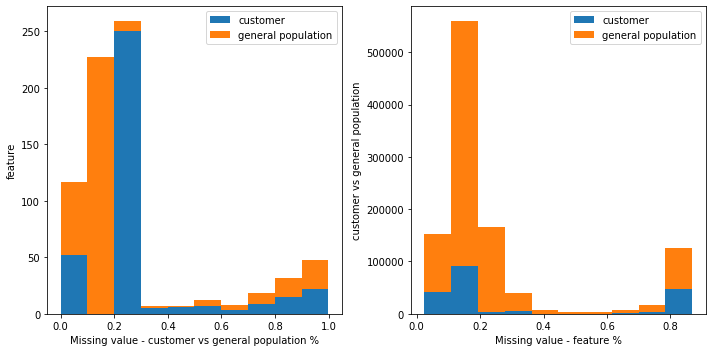

In [109]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((new_customers_df.isnull().mean(), new_azdias_df.isnull().mean()), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - customer vs general population %')
plt.ylabel('feature')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((new_customers_df.isnull().mean(axis=1), new_azdias_df.isnull().mean(axis=1)), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - feature %')
plt.ylabel('customer vs general population')
plt.legend()

plt.tight_layout()
plt.show()

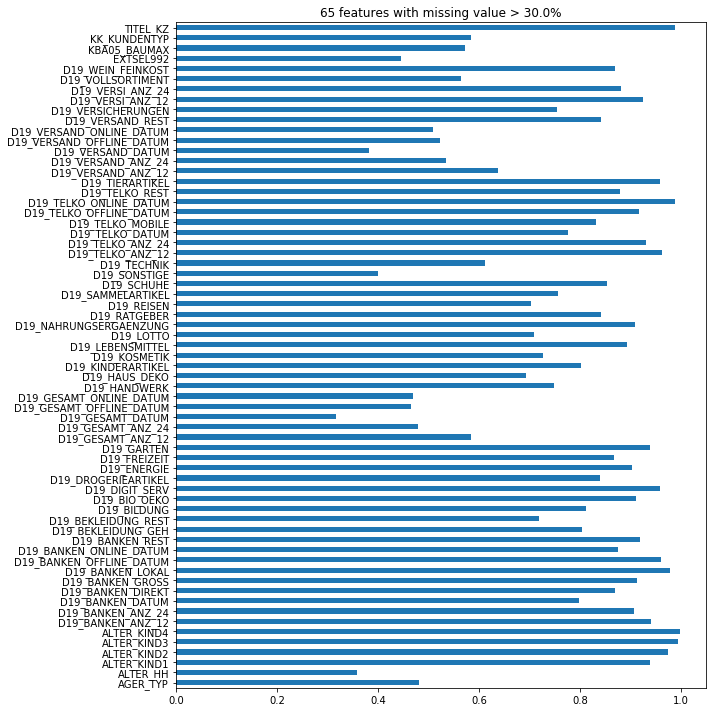

In [110]:
_ = np.setdiff1d(new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO], annot_attr_azdias_values_dict['unused'])
_ = np.union1d(_, np.setdiff1d(new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO], not_annot_attr_azdias_values_dict['unused']))

plt.figure(figsize = [10, 10])
new_customers_df[_].isnull().mean().plot.barh()
plt.title('{} features with missing value > {}%'.format(np.setdiff1d(_, 'LNR').size, FEATURE_DROP_RATIO*100))
plt.tight_layout()
plt.show()

#### Analyze categorical feature

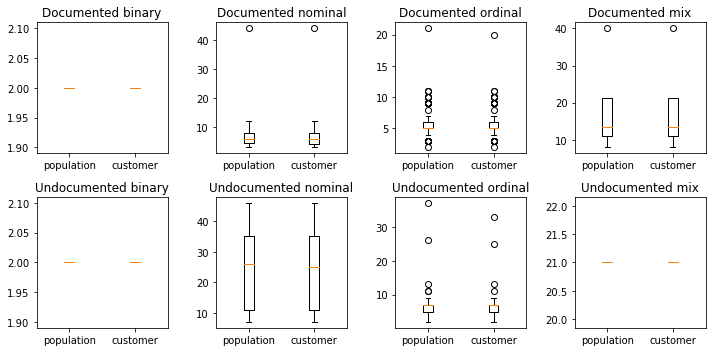

In [111]:
plt.figure(figsize = [10, 5])

plt.subplot(2,4,1)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['bin_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['bin_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented binary')

plt.subplot(2,4,2)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['nom_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['nom_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented nominal')

plt.subplot(2,4,3)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['ord_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['ord_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented ordinal')

plt.subplot(2,4,4)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['mix_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['mix_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented mix')

plt.subplot(2,4,5)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['bin_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['bin_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented binary')

plt.subplot(2,4,6)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['nom_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['nom_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented nominal')

plt.subplot(2,4,7)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['ord_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['ord_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented ordinal')

plt.subplot(2,4,8)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['mix_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['mix_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented mix')

plt.tight_layout()
plt.show()

Analyze `annot_attr_azdias_values_dict['nom_cat']`

In [112]:
for v in annot_attr_azdias_values_dict['nom_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

CAMEO_DEU_2015 have 44 unique values (>15)


__NOTE__: drop CAMEO_DEU_2015 (44 unique value, too large)

Analyze `annot_attr_azdias_values_dict['ord_cat']`

In [113]:
for v in annot_attr_azdias_values_dict['ord_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

ALTER_HH have 21 unique values (>15)


__NOTE__: drop ALTER_HH (21 unique value, too large)

Analyze `annot_attr_azdias_values_dict['mix_cat']`

LP_LEBENSPHASE_FEIN: **contains information about life stage and fine scale. I will create two new ordinals features, one for life_stage and other for fine_scale**

In [114]:
age_dict = {'younger_age': 0, 'middle_age': 1, 'advanced_age': 2, 'retirement_age': 3}
life_stage = {1: age_dict['younger_age'], 2: age_dict['middle_age'], 3: age_dict['younger_age'],
              4: age_dict['middle_age'], 5: age_dict['advanced_age'], 6: age_dict['retirement_age'],
              7: age_dict['advanced_age'], 8: age_dict['retirement_age'], 9: age_dict['middle_age'],
              10: age_dict['middle_age'], 11: age_dict['advanced_age'], 12: age_dict['retirement_age'],
              13: age_dict['advanced_age'], 14: age_dict['younger_age'], 15: age_dict['advanced_age'],
              16: age_dict['advanced_age'], 17: age_dict['middle_age'], 18: age_dict['younger_age'],
              19: age_dict['advanced_age'], 20: age_dict['advanced_age'], 21: age_dict['middle_age'],
              22: age_dict['middle_age'], 23: age_dict['middle_age'], 24: age_dict['middle_age'],
              25: age_dict['middle_age'], 26: age_dict['middle_age'], 27: age_dict['middle_age'],
              28: age_dict['middle_age'], 29: age_dict['younger_age'], 30: age_dict['younger_age'],
              31: age_dict['advanced_age'], 32: age_dict['advanced_age'], 33: age_dict['younger_age'],
              34: age_dict['younger_age'], 35: age_dict['younger_age'], 36: age_dict['advanced_age'],
              37: age_dict['advanced_age'], 38: age_dict['retirement_age'], 39: age_dict['middle_age'],
              40: age_dict['retirement_age']}

fine_dict = {'low': 0, 'average': 1, 'wealthy': 2, 'top': 3}                                                                                      
fine_scale = {1: fine_dict['low'], 2: fine_dict['low'], 3: fine_dict['average'], 4: fine_dict['average'], 5: fine_dict['low'], 6: fine_dict['low'],
              7: fine_dict['average'], 8: fine_dict['average'], 9: fine_dict['average'], 10: fine_dict['wealthy'], 11: fine_dict['average'],
              12: fine_dict['average'], 13: fine_dict['top'], 14: fine_dict['average'], 15: fine_dict['low'], 16: fine_dict['average'],
              17: fine_dict['average'], 18: fine_dict['wealthy'], 19: fine_dict['wealthy'], 20: fine_dict['top'], 21: fine_dict['low'],
              22: fine_dict['average'], 23: fine_dict['wealthy'], 24: fine_dict['low'], 25: fine_dict['average'], 26: fine_dict['average'],
              27: fine_dict['average'], 28: fine_dict['top'], 29: fine_dict['low'], 30: fine_dict['average'], 31: fine_dict['low'],
              32: fine_dict['average'], 33: fine_dict['average'], 34: fine_dict['average'], 35: fine_dict['top'], 36: fine_dict['average'],
              37: fine_dict['average'], 38: fine_dict['average'], 39: fine_dict['top'], 40: fine_dict['top']}

new_azdias_df['LP_life_stage'] = new_azdias_df['LP_LEBENSPHASE_FEIN'].map(life_stage)
new_azdias_df['LP_fine_scale'] = new_azdias_df['LP_LEBENSPHASE_FEIN'].map(fine_scale)
new_customers_df['LP_life_stage'] = new_customers_df['LP_LEBENSPHASE_FEIN'].map(life_stage)
new_customers_df['LP_fine_scale'] = new_customers_df['LP_LEBENSPHASE_FEIN'].map(fine_scale)

LP_LEBENSPHASE_GROB **contains the same information as LP_LEBENSPHASE_FEIN. Therefore I will drop it.**

PRAEGENDE_JUGENDJAHRE: **combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.**

In [115]:
# Map decade
dec_dic = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
           8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
           15: 90, np.nan: np.nan, -1: np.nan, 0: np.nan}

# Map mouvement
mov_dic = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
           np.nan: np.nan, -1: np.nan, 0: np.nan}

new_azdias_df['PRAEGENDE_JUGENDJAHRE_dec'] = new_azdias_df['PRAEGENDE_JUGENDJAHRE'].map(dec_dic)
new_azdias_df['PRAEGENDE_JUGENDJAHRE_mov'] = new_azdias_df['PRAEGENDE_JUGENDJAHRE'].map(mov_dic)
new_customers_df['PRAEGENDE_JUGENDJAHRE_dec'] = new_customers_df['PRAEGENDE_JUGENDJAHRE'].map(dec_dic)
new_customers_df['PRAEGENDE_JUGENDJAHRE_mov'] = new_customers_df['PRAEGENDE_JUGENDJAHRE'].map(mov_dic)

WOHNLAGE: **We create two new features NEIGHBORHOOD_QUALITY (Ordinal, vaulues from 1 to 5) and RURAL (Binary, 0= non-rural, 1=rural)**

In [116]:
new_azdias_df[(new_azdias_df['WOHNLAGE'] > 0) & (new_azdias_df['WOHNLAGE'] < 7)]['WOHNLAGE'].count()/new_azdias_df.shape[0]

0.678094434489313

In [117]:
rural_dict = {1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 8:1}

new_azdias_df['WOHNLAGE_rural'] = new_azdias_df['WOHNLAGE'].map(dec_dic)

In [118]:
new_customers_df['WOHNLAGE_rural'] = new_customers_df['WOHNLAGE'].map(dec_dic)

Analyze `not_annot_attr_azdias_values_dict['nom_cat']`

In [119]:
for v in not_annot_attr_azdias_values_dict['nom_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

D19_LETZTER_KAUF_BRANCHE have 35 unique values (>15)
EINGEFUEGT_AM have 26 unique values (>15)
VERDICHTUNGSRAUM have 46 unique values (>15)


__NOTE__: drop D19_LETZTER_KAUF_BRANCHE (35 unique value, too large) ,drop EINGEFUEGT_AM (26 unique value, too large), drop VERDICHTUNGSRAUM (46 unique value, too large)

Analyze `not_annot_attr_azdias_values_dict['ord_cat']`

In [120]:
for v in not_annot_attr_azdias_values_dict['ord_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

ALTERSKATEGORIE_FEIN have 26 unique values (>15)
EINGEZOGENAM_HH_JAHR have 37 unique values (>15)


__NOTE__: drop ALTERSKATEGORIE_FEIN (26 unique value, too large), drop EINGEZOGENAM_HH_JAHR (37 unique value, too large)

Analyze `not_annot_attr_azdias_values_dict['mix_cat']`

In [121]:
new_azdias_df['CAMEO_INTL_2015_wealth'] = new_azdias_df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
new_azdias_df['CAMEO_INTL_2015_family'] = new_azdias_df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)

new_customers_df['CAMEO_INTL_2015_wealth'] = new_customers_df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
new_customers_df['CAMEO_INTL_2015_family'] = new_customers_df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan) 

#### Analyze quantitative feature

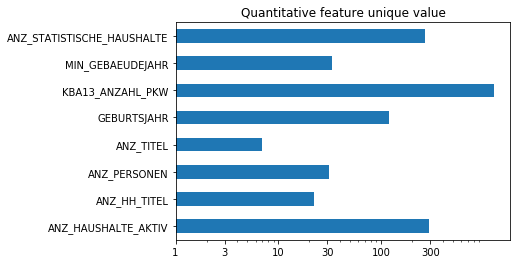

In [122]:
ax = new_azdias_df[annot_attr_azdias_values_dict['num']].nunique().append(new_azdias_df[not_annot_attr_azdias_values_dict['num']].nunique()).plot.barh(log=True)
ax.set_xticks([1, 3, 10, 30, 100, 300])
ax.set_xticklabels(['1', '3', '10', '30', '100', '300'])
plt.title('Quantitative feature unique value')
plt.show()

In [123]:
for v in np.union1d(annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['num']):
    nunique =  new_azdias_df[v].nunique()
    if nunique < 15:
        print('{} have {} unique values (<15)'.format(v, new_azdias_df[v].nunique()))

ANZ_TITEL have 6 unique values (<15)


__NOTE__: ANZ_TITEL: move to ordinal categorical feature, because their unique are too small.

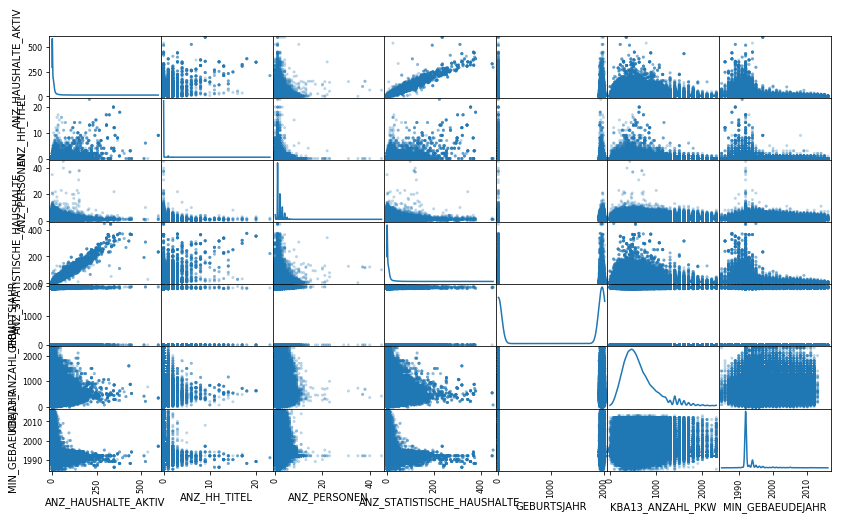

In [125]:
_ = np.union1d(annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['num'])
_ = np.setdiff1d(_, ['ANZ_TITEL'])

_ = new_azdias_df[_]
pd.plotting.scatter_matrix(_, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
plt.show()

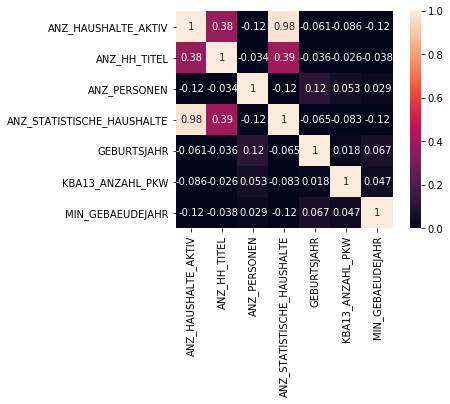

In [126]:
_ = _.corr()
sns.heatmap(_, vmin=0, vmax=1, annot=True, square=True)
plt.show()

__NOTE__: 
1. ANZ_STATISTISCHE_HAUSHALTE: drop (too similar to ANZ_HAUSHALTE_AKTIV)
2. The others: log transform

Analyze GEBURTSJAHR (year of birth)

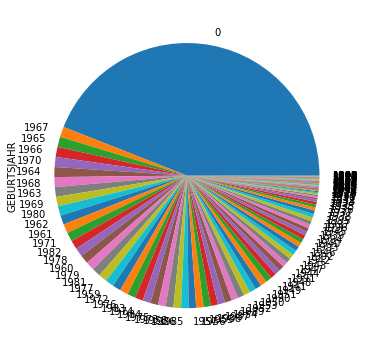

In [127]:
plt.figure(figsize = [10, 5])
azdias_df['GEBURTSJAHR'].value_counts().plot.pie()
plt.tight_layout()
plt.show()

__NOTE__: GEBURTSJAHR: drop (almost half are year of birth = 0, abnormal)

In [124]:
col_outlier = np.array(['ALTERSKATEGORIE_FEIN', 'ALTER_HH', 'ANZ_STATISTISCHE_HAUSHALTE',
       'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
       'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'VERDICHTUNGSRAUM', 'WOHNLAGE'])

In [125]:
annot_attr_azdias_values = np.union1d(annot_attr_azdias_values, ['LP_life_stage', 
                                                                 'LP_fine_scale', 
                                                                 'PRAEGENDE_JUGENDJAHRE_dec', 
                                                                 'PRAEGENDE_JUGENDJAHRE_mov',
                                                                 'WOHNLAGE_rural'])

annot_attr_azdias_values_dict['unused'] = np.union1d(annot_attr_azdias_values_dict['unused'], annot_attr_azdias_values_dict['mix_cat'])
annot_attr_azdias_values_dict['unused'] = np.union1d(annot_attr_azdias_values_dict['unused'], ['CAMEO_DEU_2015', 'ALTER_HH', 'GEBURTSJAHR'])
annot_attr_azdias_values_dict['mix_cat'] = np.array([])
annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['nom_cat'], 'CAMEO_DEU_2015')
annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['ord_cat'], 'ALTER_HH')
annot_attr_azdias_values_dict['ord_cat'] = np.union1d(annot_attr_azdias_values_dict['ord_cat'], ['ANZ_TITEL'])
annot_attr_azdias_values_dict['nom_cat'] = np.union1d(annot_attr_azdias_values_dict['nom_cat'], ['LP_life_stage', \
                                                                                                 'LP_fine_scale', \
                                                                                                 'PRAEGENDE_JUGENDJAHRE_dec', \
                                                                                                 'PRAEGENDE_JUGENDJAHRE_mov', \
                                                                                                 'WOHNLAGE_rural'])
annot_attr_azdias_values_dict['num'] = np.setdiff1d(annot_attr_azdias_values_dict['num'], ['ANZ_TITEL', 'GEBURTSJAHR'])

not_annot_attr_azdias_values = np.union1d(not_annot_attr_azdias_values, ['CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_family'])

not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], not_annot_attr_azdias_values_dict['mix_cat'])
not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM', 'ANZ_STATISTISCHE_HAUSHALTE'])
not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], ['ALTERSKATEGORIE_FEIN', 'EINGEZOGENAM_HH_JAHR'])                                                 
not_annot_attr_azdias_values_dict['mix_cat'] = np.array([])
not_annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['nom_cat'], ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM'])
not_annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['ord_cat'], ['ALTERSKATEGORIE_FEIN', 'EINGEZOGENAM_HH_JAHR'])
not_annot_attr_azdias_values_dict['nom_cat'] = np.union1d(not_annot_attr_azdias_values_dict['nom_cat'], ['CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_family'])
not_annot_attr_azdias_values_dict['num'] = np.setdiff1d(not_annot_attr_azdias_values_dict['num'], ['ANZ_STATISTISCHE_HAUSHALTE'])

In [126]:
annot_attr_azdias_values_dict['unused'] = np.union1d(annot_attr_azdias_values_dict['unused'], \
                                np.intersect1d(np.concatenate(list(annot_attr_azdias_values_dict.values())), new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO]))
annot_attr_azdias_values_dict['bin_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['bin_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['nom_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['ord_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['mix_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['mix_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['num'] = np.setdiff1d(annot_attr_azdias_values_dict['num'], annot_attr_azdias_values_dict['unused'])

/Users/fc/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [127]:
not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], \
                                np.intersect1d(np.concatenate(list(not_annot_attr_azdias_values_dict.values())), new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO]))
not_annot_attr_azdias_values_dict['bin_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['bin_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['nom_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['ord_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['mix_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['mix_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['num'] = np.setdiff1d(not_annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['unused'])

/Users/fc/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [128]:
assert annot_attr_azdias_values.size == annot_attr_azdias_values_dict['bin_cat'].size \
                                        + annot_attr_azdias_values_dict['nom_cat'].size \
                                        + annot_attr_azdias_values_dict['ord_cat'].size \
                                        + annot_attr_azdias_values_dict['mix_cat'].size \
                                        + annot_attr_azdias_values_dict['num'].size \
                                        + annot_attr_azdias_values_dict['unused'].size

In [129]:
assert not_annot_attr_azdias_values.size == not_annot_attr_azdias_values_dict['bin_cat'].size \
                                            + not_annot_attr_azdias_values_dict['nom_cat'].size \
                                            + not_annot_attr_azdias_values_dict['ord_cat'].size \
                                            + not_annot_attr_azdias_values_dict['mix_cat'].size \
                                            + not_annot_attr_azdias_values_dict['num'].size \
                                            + not_annot_attr_azdias_values_dict['unused'].size

unused features

In [130]:
def drop(df, customer_drop_ratio=CUSTOMER_DROP_RATIO, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    customer_drop_ratio - drop ratio for customer
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Drop customers and unused features.
    '''
    ## drop customer
    df = df.loc[df.isnull().mean(axis=1) < customer_drop_ratio]
    
    ## drop ferature
    cols = [v for k in annot_dict.keys() for v in annot_dict[k]]
    cols += [v for k in not_annot_dict.keys() for v in not_annot_dict[k]]
    cols = np.setdiff1d(cols, annot_dict['unused'])
    cols = np.setdiff1d(cols, not_annot_dict['unused'])
    df = df[cols]
    
    return df

In [135]:
new_azdias_df = drop(new_azdias_df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict)
new_customers_df = drop(new_customers_df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict)

In [136]:
new_azdias_df.to_pickle('new_azdias_df_drop.pickle')
new_customers_df.to_pickle('new_customers_df_drop.pickle')

In [131]:
new_azdias_df = pd.read_pickle("new_azdias_df_drop.pickle")
new_customers_df = pd.read_pickle("new_customers_df_drop.pickle")

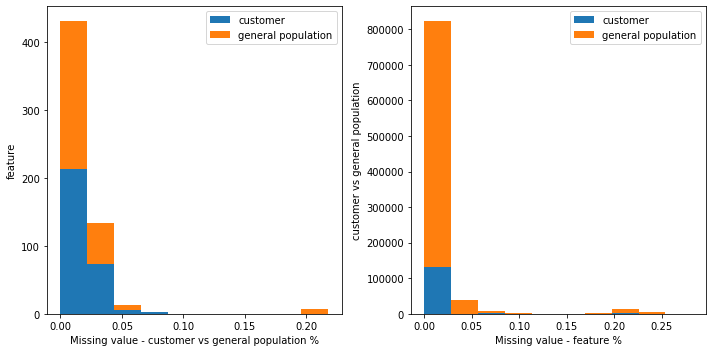

In [132]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((new_customers_df.isnull().mean(), new_azdias_df.isnull().mean()), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - customer vs general population %')
plt.ylabel('feature')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((new_customers_df.isnull().mean(axis=1), new_azdias_df.isnull().mean(axis=1)), stacked=True, label=['customer', 'general population'])
plt.xlabel('Missing value - feature %')
plt.ylabel('customer vs general population')
plt.legend()

plt.tight_layout()
plt.show()

We can find customers missing value been bounded by generation population, which means this is a sufficient drop.

In [133]:
def cover(population_df, sample_df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    population_df - pandas dataframe for general population
    sample_df - pandas dataframe for sample
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    Description: Scan feature overlay with general population and customer.
    '''
    for col in population_df.columns:
        if not np.isin(col, np.union1d(annot_dict['num'], not_annot_dict['num'])):       
            population_v = population_df[col].dropna().unique()
            sample_v = sample_df[col].dropna().unique()

            diff_population_v = np.setdiff1d(population_v, sample_v)
            diff_sample_v = np.setdiff1d(sample_v, population_v)

            if diff_sample_v.size > 0:
                print('{} have value only in sample : {}'.format(col, diff_sample_v))
            if col in annot_dict['nom_cat'].tolist()+not_annot_dict['nom_cat'].tolist():
                if diff_population_v.size > 0:
                    print('nom_cat type {} have value only in population : {}'.format(col, diff_population_v)) 
                
        else:
            max_population_v = population_df[col].dropna().max()
            min_population_v = population_df[col].dropna().min()

            max_sample_v = sample_df[col].dropna().max()
            min_sample_v = sample_df[col].dropna().min()

            if min_population_v > min_sample_v:
                print('{} in general population have min value: {} larger than sample: {}'.format(col, min_population_v, min_sample_v))
            if max_population_v < max_sample_v:
                print('{} in general population have max value: {} smaller than sample: {}'.format(col, max_population_v, max_sample_v))

cover(new_azdias_df, new_customers_df)

ANZ_TITEL have value only in sample : [5.]
D19_TELKO_ONLINE_QUOTE_12 have value only in sample : [3.]
nom_cat type GEBAEUDETYP have value only in population : [5.]


In [134]:
new_customers_df.shape

(137415, 294)

__NOTE__: remove 1 outlier in customer - ANZ_TITEL = 5

In [135]:
new_customers_df = new_customers_df.iloc[np.where(new_customers_df['ANZ_TITEL'] != 5)[0]]

__NOTE__: remove 1 outlier in customer - D19_TELKO_ONLINE_QUOTE_12 = 3

In [136]:
new_customers_df = new_customers_df.iloc[np.where(new_customers_df['D19_TELKO_ONLINE_QUOTE_12'] != 3)[0]]

In [137]:
new_customers_df.shape

(137413, 294)

In [138]:
new_azdias_df.shape

(753747, 294)

__NOTE__: remove 1 outlier in general population - GEBAEUDETYP = 5

In [139]:
new_azdias_df = new_azdias_df.iloc[np.where(new_azdias_df['GEBAEUDETYP'] != 5)[0]]

In [140]:
new_azdias_df.shape

(753746, 294)

In [141]:
def fillna(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Fill every NA field a value. Categorical feature: max, Quantitative feature: median
    '''
    cat_cols = annot_dict['bin_cat'].tolist() + not_annot_dict['bin_cat'].tolist() \
                + annot_dict['nom_cat'].tolist() + not_annot_dict['nom_cat'].tolist() \
                + annot_dict['ord_cat'].tolist() + not_annot_dict['ord_cat'].tolist()
    for col in df.columns:
        if col in cat_cols:
            # cztegorical feature
            # Max fill function for categorical
            df[col] = df[col].fillna(df[col].value_counts().idxmax())
            
        else:
            # quantitaive feature
            # Filling missing values with medians of the columns
            df[col] = df[col].fillna(df[col].median())
    return df

In [148]:
new_azdias_df = fillna(new_azdias_df)

In [149]:
new_customers_df = fillna(new_customers_df)

In [150]:
new_customers_df.to_pickle('new_customers_df_fillna.pickle')
new_azdias_df.to_pickle('new_azdias_df_fillna.pickle')

In [142]:
new_customers_df = pd.read_pickle("new_customers_df_fillna.pickle")
new_azdias_df = pd.read_pickle("new_azdias_df_fillna.pickle")

In [143]:
assert new_azdias_df.isnull().mean().sum() == 0

In [144]:
def onehot(df, cols):
    '''
    INPUT:
    df - pandas dataframe
    cols - columns to perform one-hot encoding
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Apply one-hot encoding aming nominal categorical features.
    '''
    for col in cols:
        dummy_df = pd.get_dummies(df[col], prefix=col, prefix_sep='_')
        
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(col, axis=1), dummy_df], axis=1)
    
    return df

In [145]:
onehot_cols = np.union1d(annot_attr_azdias_values_dict['nom_cat'], not_annot_attr_azdias_values_dict['nom_cat'])
onehot_cols

array(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015_family',
       'CAMEO_INTL_2015_wealth', 'CJT_GESAMTTYP', 'D19_KONSUMTYP',
       'FINANZTYP', 'GEBAEUDETYP', 'GEMEINDETYP', 'GFK_URLAUBERTYP',
       'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_fine_scale', 'LP_life_stage', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE_dec', 'PRAEGENDE_JUGENDJAHRE_mov',
       'SHOPPER_TYP', 'VK_DHT4A', 'WOHNLAGE_rural', 'ZABEOTYP'],
      dtype=object)

In [146]:
new_azdias_df.shape

(753746, 294)

In [156]:
new_azdias_df = onehot(new_azdias_df, onehot_cols)

In [157]:
new_azdias_df.shape

(753746, 399)

In [158]:
new_customers_df = onehot(new_customers_df, onehot_cols)

In [159]:
new_azdias_df.to_pickle('new_azdias_df_onehot.pickle')
new_customers_df.to_pickle('new_customers_df_onehot.pickle')

In [147]:
new_azdias_df = pd.read_pickle("new_azdias_df_onehot.pickle")
new_customers_df = pd.read_pickle("new_customers_df_onehot.pickle")

In [148]:
assert new_azdias_df.shape[1] == new_customers_df.shape[1]

In [149]:
def log_transform(df, cols):
    '''
    INPUT:
    df - pandas dataframe
    cols - log transfer comlumns
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Normalize quantitative feature with log transfor.
    '''
    for col in cols:
        df[col] = np.log1p(df[col])
    
    return df

In [150]:
log_cols = np.union1d(annot_attr_azdias_values_dict['num'], annot_attr_azdias_values_dict['num'])
log_cols

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN',
       'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'], dtype=object)

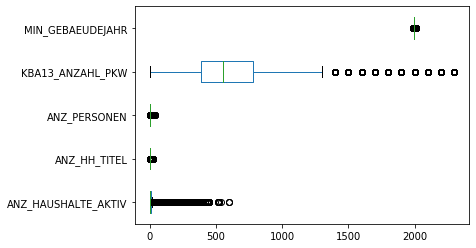

In [151]:
new_azdias_df[log_cols].plot.box(vert=False)
plt.show()

In [152]:
new_azdias_df = log_transform(new_azdias_df, log_cols)

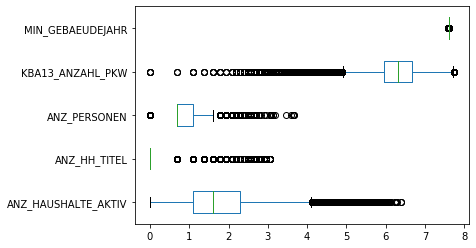

In [153]:
new_azdias_df[log_cols].plot.box(vert=False)
plt.show()

In [154]:
new_customers_df = log_transform(new_customers_df, log_cols)

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [155]:
def remove_outlier(df, cols, ratio=.3):
    '''
    INPUT:
    df - pandas dataframe
    cols - find outlier columns
    ratio - ratio feature are all outlier will be considered as true outlier
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Remove quantitative feature outliers with Tukey's Method.
    '''
    outliers  = pd.Series([])
    sol = []
    
    i = 0

    # For each feature find the data points with extreme high or low values
    for col in cols:
    
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[col], 25)

        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[col], 75)

        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)

        outlier_df = df[~((df[col] >= Q1 - step) & (df[col] <= Q3 + step))]

        outlier = outlier_df.index.to_series()
        outliers = pd.concat([outliers, outlier])

    # Select the indices for data points you wish to remove
    outliers_v = outliers[outliers.value_counts() >= cols.size*ratio].unique()
    
    print('remove {} common outliers over {} feature'.format(len(outliers_v), cols.size*ratio))
    df = df.drop(outliers_v)
    
    return df

In [156]:
new_azdias_df.shape

(753746, 391)

In [170]:
new_azdias_df = remove_outlier(new_azdias_df, log_cols)
new_azdias_df.shape

remove 29022 common outliers over 1.5 feature


(724724, 399)

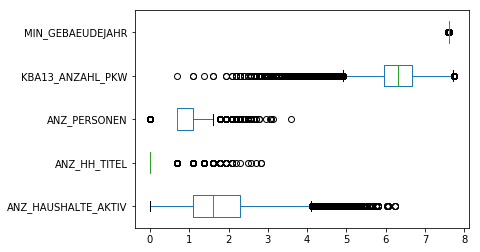

In [171]:
new_azdias_df[log_cols].plot.box(vert=False)
plt.show()

In [172]:
new_customers_df = remove_outlier(new_customers_df, log_cols)

remove 4416 common outliers over 1.5 feature


In [173]:
new_customers_df.to_pickle('new_customers_df_outlier.pickle')
new_azdias_df.to_pickle('new_azdias_df_outlier.pickle')

### Put it all together

Create a `clean_data` function to apply all steps of Data Preprocessing.

In [ ]:
def handle_mix_cat(df):
    '''
    INPUT:
    df - pandas dataframe
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Create nom_cat column from mix_cat column.
    '''
    # map LP_LEBENSPHASE_FEIN to LP_life_stage and LP_fine_scale
    age_dict = {'younger_age': 0, 'middle_age': 1, 'advanced_age': 2, 'retirement_age': 3}
    life_stage = {1: age_dict['younger_age'], 2: age_dict['middle_age'], 3: age_dict['younger_age'],
                  4: age_dict['middle_age'], 5: age_dict['advanced_age'], 6: age_dict['retirement_age'],
                  7: age_dict['advanced_age'], 8: age_dict['retirement_age'], 9: age_dict['middle_age'],
                  10: age_dict['middle_age'], 11: age_dict['advanced_age'], 12: age_dict['retirement_age'],
                  13: age_dict['advanced_age'], 14: age_dict['younger_age'], 15: age_dict['advanced_age'],
                  16: age_dict['advanced_age'], 17: age_dict['middle_age'], 18: age_dict['younger_age'],
                  19: age_dict['advanced_age'], 20: age_dict['advanced_age'], 21: age_dict['middle_age'],
                  22: age_dict['middle_age'], 23: age_dict['middle_age'], 24: age_dict['middle_age'],
                  25: age_dict['middle_age'], 26: age_dict['middle_age'], 27: age_dict['middle_age'],
                  28: age_dict['middle_age'], 29: age_dict['younger_age'], 30: age_dict['younger_age'],
                  31: age_dict['advanced_age'], 32: age_dict['advanced_age'], 33: age_dict['younger_age'],
                  34: age_dict['younger_age'], 35: age_dict['younger_age'], 36: age_dict['advanced_age'],
                  37: age_dict['advanced_age'], 38: age_dict['retirement_age'], 39: age_dict['middle_age'],
                  40: age_dict['retirement_age']}

    fine_dict = {'low': 0, 'average': 1, 'wealthy': 2, 'top': 3}                                                                                      
    fine_scale = {1: fine_dict['low'], 2: fine_dict['low'], 3: fine_dict['average'], 4: fine_dict['average'], 5: fine_dict['low'], 6: fine_dict['low'],
                  7: fine_dict['average'], 8: fine_dict['average'], 9: fine_dict['average'], 10: fine_dict['wealthy'], 11: fine_dict['average'],
                  12: fine_dict['average'], 13: fine_dict['top'], 14: fine_dict['average'], 15: fine_dict['low'], 16: fine_dict['average'],
                  17: fine_dict['average'], 18: fine_dict['wealthy'], 19: fine_dict['wealthy'], 20: fine_dict['top'], 21: fine_dict['low'],
                  22: fine_dict['average'], 23: fine_dict['wealthy'], 24: fine_dict['low'], 25: fine_dict['average'], 26: fine_dict['average'],
                  27: fine_dict['average'], 28: fine_dict['top'], 29: fine_dict['low'], 30: fine_dict['average'], 31: fine_dict['low'],
                  32: fine_dict['average'], 33: fine_dict['average'], 34: fine_dict['average'], 35: fine_dict['top'], 36: fine_dict['average'],
                  37: fine_dict['average'], 38: fine_dict['average'], 39: fine_dict['top'], 40: fine_dict['top']}

    df['LP_life_stage'] = df['LP_LEBENSPHASE_FEIN'].map(life_stage)
    df['LP_fine_scale'] = df['LP_LEBENSPHASE_FEIN'].map(fine_scale)ustomers_df['LP_LEBENSPHASE_FEIN'].map(life_stage)
    
    # map PRAEGENDE_JUGENDJAHRE to PRAEGENDE_JUGENDJAHRE_dec and PRAEGENDE_JUGENDJAHRE_mov
    # Map decade
    dec_dic = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
               8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
               15: 90, np.nan: np.nan, -1: np.nan, 0: np.nan}

    # Map mouvement
    mov_dic = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
               9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
               np.nan: np.nan, -1: np.nan, 0: np.nan}

    df['PRAEGENDE_JUGENDJAHRE_dec'] = df['PRAEGENDE_JUGENDJAHRE'].map(dec_dic)
    df['PRAEGENDE_JUGENDJAHRE_mov'] = df['PRAEGENDE_JUGENDJAHRE'].map(mov_dic)
    
    # map CAMEO_INTL_2015 to CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_family
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_family'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    
    return df

In [206]:
def clean_data(df):
    
    # Convert all unknown value to NA.
    print('unknown2na...')
    unknown2na(df)
    
    # Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
    print('formatit...')
    formatit(df)
    return df

    # Create nom_cat column from mix_cat column.
    handle_mix_cat(df)
    
    # Drop customers and unused features.
    drop(df)
    
    # Scan feature coverage with general population and customer.
    cover(df)
    
    # Fill every NA field a value. Categorical feature: max, Quantitative feature: median
    fillna(df)
    
    # Apply one-hot encoding aming nominal categorical features.
    onehot(df)
    
    # Normalize quantitative feature with log transfor.
    log_transform(df)
    
    # Remove quantitative feature outliers with Tukey's Method.
    remove_outlier(df)
    
    return df

In [205]:
_ = customers_df.copy()
_ = clean_data(_)

unknown2na...
formatit...


[========================================================================] 100%


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Feature Transformation

In [157]:
new_customers_df = pd.read_pickle("new_customers_df_outlier.pickle")
new_azdias_df = pd.read_pickle("new_azdias_df_outlier.pickle")

In [158]:
assert new_azdias_df.shape[1] == new_customers_df.shape[1]

In [159]:
new_azdias_df.shape

(724724, 391)

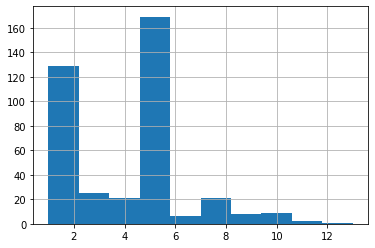

In [160]:
new_azdias_df.max().hist()
plt.show()

Perform RobostScaler to best handle outliers.

In [161]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
new_azdias_df = pd.DataFrame(scaler.fit_transform(new_azdias_df.values), columns=new_azdias_df.columns)
new_customers_df = pd.DataFrame(scaler.fit_transform(new_customers_df.values), columns=new_customers_df.columns)

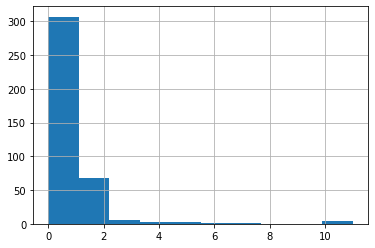

In [162]:
new_azdias_df.max().hist()
plt.show()

#### PCA

What we want to do here ...

* **PCA**: User PCA to find how many components, `N_COMPONENTS`,will best describe total feature variance.
* **Dimensionality Reduction**: User `N_COMPONENTS` to create new simplified dataframe.

In [163]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
new_azdias_pca = PCA().fit(new_azdias_df)

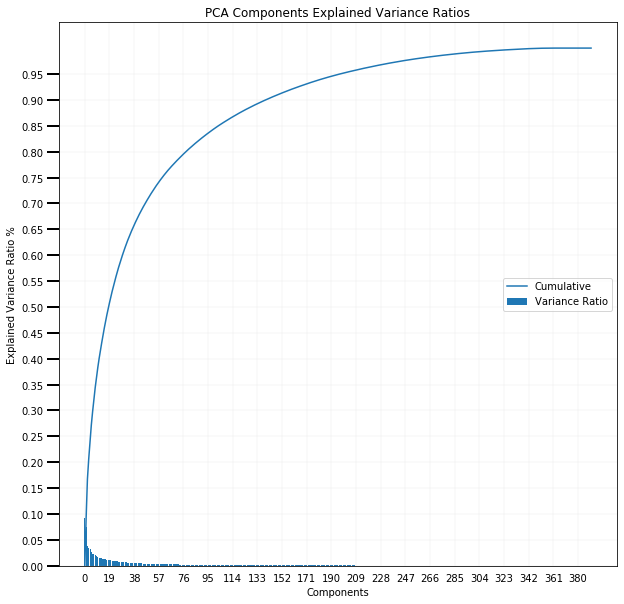

In [164]:
def show_pca(pca):
    """    
    INPUT:
        pca: an sklearn.decomposition.pca.PCA object    
    
    OUTPUT:
        None (visualizes a plot)
    
    DESCRIPTION:
        Visualize the curves of the explained variance ratio for each component and the cumulative ratios
    """
    cumulative_ratios=np.zeros(len(pca.explained_variance_ratio_))
    
    for i in range(len(pca.explained_variance_ratio_)):
        cumulative_ratios[i]=np.sum(pca.explained_variance_ratio_[:i])
        
    plt.figure(figsize=(10,10))
    
    plt.bar(x=np.arange(len(pca.explained_variance_ratio_)), height=pca.explained_variance_ratio_)
    plt.plot(cumulative_ratios)
    
    plt.xlabel("Components")
    plt.ylabel("Explained Variance Ratio %")
    plt.title("PCA Components Explained Variance Ratios")
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.xticks(np.arange(0, len(pca.explained_variance_ratio_)+2, step=(len(pca.explained_variance_ratio_) // 20)))
    plt.tick_params(axis='x', width=0)
    plt.tick_params(axis='y', width=2, length=12)
    plt.grid(linewidth=0.1)
    plt.legend(['Cumulative', 'Variance Ratio'], loc='center right')
    
show_pca(new_azdias_pca)

We can use first 200 principal component to cover 95% variance.

In [165]:
sum(new_azdias_pca.explained_variance_ratio_[:200])

0.9522019581270172

In [166]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(new_azdias_pca.components_)+1)]

# PCA components
new_azdias_components_pca_df = pd.DataFrame(np.round(new_azdias_pca.components_, 4), columns = new_azdias_df.keys())
new_azdias_components_pca_df.index = dimensions

In [167]:
new_azdias_components_pca_df.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,WOHNLAGE_rural_40.0,WOHNLAGE_rural_50.0,WOHNLAGE_rural_60.0,WOHNLAGE_rural_70.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
Dimension 1,0.0288,-0.0196,0.0027,0.1304,0.0023,-0.0143,-0.0688,-0.0001,0.1316,-0.0543,...,-0.0072,0.0442,-0.0328,-0.0042,-0.0307,-0.0080,0.0075,0.0045,0.0157,0.0109
Dimension 2,0.0037,-0.0015,0.0012,0.0131,0.0028,-0.0026,-0.0121,0.0006,-0.0441,-0.0521,...,0.0273,0.0075,-0.0323,-0.0026,0.0065,0.0021,-0.0025,-0.0055,-0.0019,0.0013
Dimension 3,-0.0074,-0.0930,-0.0090,0.0051,-0.0004,0.0464,0.0756,-0.0004,-0.0224,-0.0096,...,-0.0049,0.0020,0.0008,0.0022,0.0101,0.0057,-0.0819,0.0592,0.0150,-0.0082
Dimension 4,-0.0321,0.0405,-0.0044,0.0151,0.0010,-0.0002,0.0487,0.0003,0.1236,-0.0021,...,0.0091,0.0106,-0.0192,-0.0004,0.0013,0.0039,0.0199,-0.0065,-0.0143,-0.0043
Dimension 5,-0.0605,0.1092,-0.0079,-0.0396,0.0006,-0.0071,0.0882,0.0007,0.0150,-0.0355,...,0.0137,0.0149,-0.0265,-0.0021,0.0151,0.0033,0.0570,-0.0302,-0.0401,-0.0051


#### Dimension 1

In [168]:
new_azdias_components_pca_df.iloc[0].sort_values(ascending=False)

KBA13_ANTG3                   0.2108
PLZ8_ANTG3                    0.2039
KBA13_BAUMAX                  0.1483
KBA13_ANTG4                   0.1447
PLZ8_ANTG4                    0.1411
PLZ8_BAUMAX                   0.1406
PLZ8_ANTG2                    0.1336
ARBEIT                        0.1316
ANZ_HAUSHALTE_AKTIV           0.1304
ORTSGR_KLS9                   0.1287
HH_EINKOMMEN_SCORE            0.1240
KBA05_ANTG3                   0.1202
D19_VERSI_DATUM               0.1160
KBA13_ANTG2                   0.1074
KBA13_VORB_3                  0.0979
EWDICHTE                      0.0977
FINANZ_HAUSBAUER              0.0927
KBA13_CCM_0_1400              0.0909
STRUKTURTYP                   0.0906
RELAT_AB                      0.0802
LP_fine_scale_0.0             0.0740
KBA05_ANTG4                   0.0692
KBA13_HALTER_30               0.0676
KBA13_HALTER_35               0.0667
CAMEO_INTL_2015_wealth_5.0    0.0651
KBA13_KW_50                   0.0610
VHN                           0.0609
C

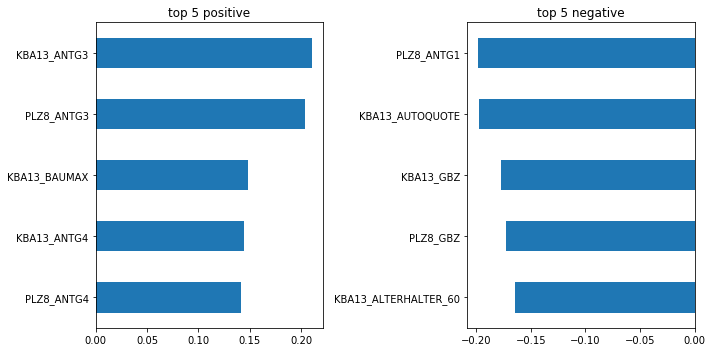

In [169]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
new_azdias_components_pca_df.iloc[0].sort_values(ascending=False).iloc[4::-1].plot.barh()
plt.title('top 5 positive')

plt.subplot(1,2,2)
new_azdias_components_pca_df.iloc[0].sort_values(ascending=False).iloc[-5:].plot.barh()
plt.title('top 5 negative')

plt.tight_layout()
plt.show()

**Postiive correlation**
* KBA13_ANTG3: 0.2109 (undocumented)
* PLZ8_ANTG3: 0.2039 (number of 6-10 family houses in the PLZ8)
* KBA13_BAUMAX: 0.1483 (undocumented)
* KBA13_ANTG4: 0.1447 (undocumented)
* PLZ8_ANTG4: 0.1411 (number of >10 family houses in the PLZ8)

**Negative correlation**
* PLZ8_ANTG1: -0.1986 (number of 1-2 family houses in the PLZ8)
* KBA13_AUTOQUOTE: -0.1972 (share of cars per household within the PLZ8)
* KBA13_GBZ: -0.1770 (undocumented)
* PLZ8_GBZ: -0.1732 (number of buildings within the PLZ8)
* KBA13_ALTERHALTER_60: -0.1643 (share of car owners between 46 and 60 within the PLZ8)

The first principal component have strong positive correlation to number of > 5 family houses, Have strong negative correlation to 40~60 year old, 1~2 family houses owner.

#### Second principal component

In [170]:
new_azdias_components_pca_df.iloc[1].sort_values(ascending=False)

KBA13_KMH_211                  0.2746
KBA13_KMH_250                  0.2710
KBA13_SEG_SPORTWAGEN           0.2640
KBA13_HERST_BMW_BENZ           0.2232
KBA13_MERCEDES                 0.1906
KBA13_SEG_OBEREMITTELKLASSE    0.1834
KBA13_BMW                      0.1827
KBA13_SITZE_4                  0.1821
KBA13_HALTER_65                0.1245
KBA05_SEG5                     0.1209
KBA13_KW_121                   0.1176
KBA13_KW_110                   0.1103
KBA13_CCM_2501                 0.1102
KBA13_SEG_OBERKLASSE           0.1086
KBA05_MOTOR                    0.1046
KBA13_ALTERHALTER_61           0.0983
KBA13_CCM_3000                 0.0976
KBA13_BJ_2008                  0.0933
KBA05_HERST1                   0.0931
KBA05_SEG8                     0.0887
KBA13_SEG_WOHNMOBILE           0.0857
KBA13_VORB_0                   0.0840
KBA13_CCM_2500                 0.0825
KBA13_SEG_GELAENDEWAGEN        0.0824
STRUKTURTYP                    0.0792
KBA05_KW3                      0.0787
KBA13_FIAT  

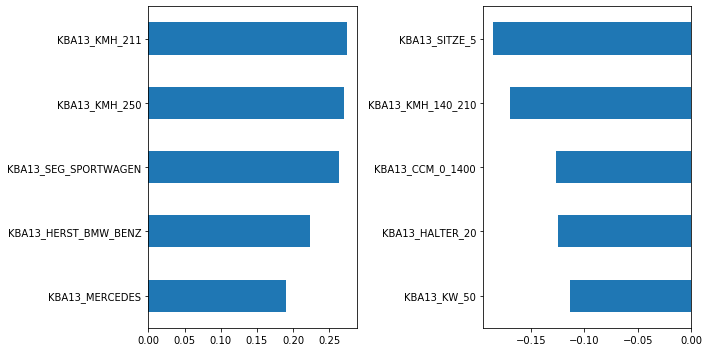

In [171]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
new_azdias_components_pca_df.iloc[1].sort_values(ascending=False).iloc[4::-1].plot.barh()

plt.subplot(1,2,2)
new_azdias_components_pca_df.iloc[1].sort_values(ascending=False).iloc[-5:].plot.barh()

plt.tight_layout()
plt.show()

**Postiive correlation**
* KBA13_KMH_211: 0.2746 (share of cars with a greater max speed than 210 km/h within the PLZ8)
* KBA13_KMH_250: 0.2710 (share of cars with max speed between 210 and 250 km/h within the PLZ8)
* KBA13_SEG_SPORTWAGEN: 0.2640 (share of sportscars within the PLZ8)
* KBA13_HERST_BMW_BENZ: 0.2232 (share of BMW & Mercedes Benz within the PLZ8)
* KBA13_MERCEDES: 0.1906 (share of MERCEDES within the PLZ8)

**Negative correlation**
* KBA13_SITZE_5: -0.1853 (number of cars with 5 seats in the PLZ8)
* KBA13_KMH_140_210: -0.1694 (share of cars with max speed between 140 and 210 km/h within the PLZ8)
* KBA13_CCM_0_1400: -0.1265 (share of cars with less than 1400ccm within the PLZ8)
* KBA13_HALTER_20: -0.1245 (share of car owners below 21 within the PLZ8)
* KBA13_KW_50: -0.1130 (share of cars with an engine power between 41 and 50 KW - PLZ8)

The second principal component have strong positive correlation to number of high performance, luxury cars, such as MW & Mercedes. Have strong negative correlation to low performance, speed, engine power car.

#### Third principal component

In [172]:
new_azdias_components_pca_df.iloc[2].sort_values(ascending=False)

D19_BANKEN_ONLINE_QUOTE_12        0.6502
SEMIO_REL                         0.1504
CJT_TYP_2                         0.1317
ONLINE_AFFINITAET                 0.1177
SEMIO_RAT                         0.1138
SEMIO_PFLICHT                     0.1022
FINANZ_SPARER                     0.0964
RT_UEBERGROESSE                   0.0936
SEMIO_TRADV                       0.0931
D19_GESAMT_ONLINE_QUOTE_12        0.0911
D19_VERSAND_ONLINE_QUOTE_12       0.0876
CJT_TYP_1                         0.0837
SEMIO_KULT                        0.0770
FINANZ_UNAUFFAELLIGER             0.0756
ANZ_PERSONEN                      0.0756
FINANZ_ANLEGER                    0.0718
PRAEGENDE_JUGENDJAHRE_dec_90.0    0.0710
SEMIO_MAT                         0.0641
ZABEOTYP_4                        0.0592
RT_KEIN_ANREIZ                    0.0573
KBA13_VORB_3                      0.0566
LP_life_stage_0.0                 0.0552
UMFELD_ALT                        0.0517
FINANZTYP_1                       0.0472
ANZ_KINDER      

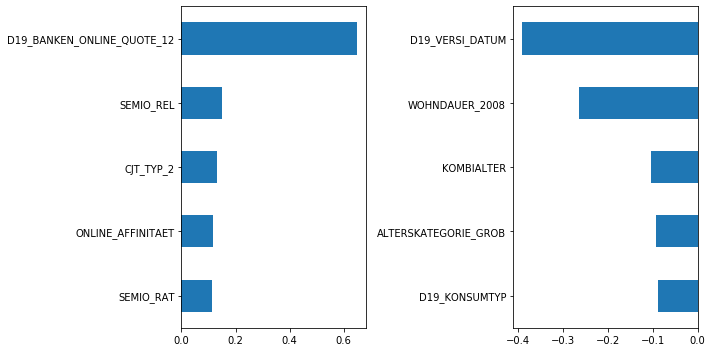

In [173]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
new_azdias_components_pca_df.iloc[2].sort_values(ascending=False).iloc[4::-1].plot.barh()

plt.subplot(1,2,2)
new_azdias_components_pca_df.iloc[2].sort_values(ascending=False).iloc[-5:].plot.barh()

plt.tight_layout()
plt.show()

**Postiive correlation**
* D19_BANKEN_ONLINE_QUOTE_12: 0.6493 (amount of online transactions within all transactions in the segment bank)
* SEMIO_REL: 0.1500 (affinity indicating in what way the person is religious)
* CJT_TYP_2: 0.1312 (undocumented)
* ONLINE_AFFINITAET: 0.1180 (online affinity)
* SEMIO_RAT: 0.1133 (affinity indicating in what way the person is of a rational mind)

**Negative correlation**
* D19_VERSI_DATUM: -0.3918 (undocumented)
* WOHNDAUER_2008: -0.2643 (length of residence)
* KOMBIALTER: -0.1035 (undocumented)
* ALTERSKATEGORIE_GROB: -0.0927 (age classification through prename analysis)
* D19_KONSUMTYP_MAX: -0.0839 (undocumented)

The third principal component have strong positive correlation to online affinity. Have strong negative correlation to residence year.

#### Dimensionality Reduction

User `N_COMPONENTS` to create new simplified dataframe.

In [174]:
N_COMPONENTS = 200

# Apply PCA by fitting the good data with only 50 dimensions
new_azdias_pca = PCA(n_components=N_COMPONENTS).fit(new_azdias_df)

# Transform the general population using the PCA fit above
reduced_data_new_azdias = new_azdias_pca.transform(new_azdias_df)

# Transform the customer using the PCA fit above
reduced_data_new_customers = new_azdias_pca.transform(new_customers_df)

# Create a DataFrame for the reduced data
new_azdias_reduced_data_df = pd.DataFrame(reduced_data_new_azdias, columns = ['Dimension '+str(i) for i in range(1, N_COMPONENTS+1)])
new_customers_reduced_data_df = pd.DataFrame(reduced_data_new_customers, columns = ['Dimension '+str(i) for i in range(1, N_COMPONENTS+1)])

In [175]:
new_azdias_reduced_data_df.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 191,Dimension 192,Dimension 193,Dimension 194,Dimension 195,Dimension 196,Dimension 197,Dimension 198,Dimension 199,Dimension 200
0,2.465658,3.241744,0.655743,-1.383134,-2.786326,0.494273,0.460986,-1.163938,-2.628822,-1.345881,...,0.817384,0.034714,0.254581,-0.152069,0.165396,-0.026687,-0.020962,-0.478874,-0.316404,0.076244
1,-1.577518,2.867757,-1.162584,0.485385,-2.403971,-0.300224,-2.024467,-0.520261,-0.275576,-1.357930,...,0.250017,0.200241,-0.162420,-0.404268,-0.300968,-0.426807,0.078638,0.500249,-0.390566,-0.226182
2,-1.469129,2.049285,9.573081,2.719217,5.306097,-5.316458,1.763527,-0.054301,-0.752876,0.168237,...,0.437618,-0.260120,0.792920,-0.136368,-0.252536,-0.234461,-0.073502,0.560000,-0.097685,0.417367
3,-3.478003,1.890868,-0.549728,0.675535,-1.424338,-0.573406,-0.901753,0.520831,-3.133695,-0.025872,...,0.098788,-0.380170,0.021323,0.004814,-0.202649,-0.432441,0.192495,-0.558804,0.677313,0.397849
4,-0.573438,-1.372946,0.299852,-4.620116,-0.922874,0.149156,-3.913256,0.391566,-0.565959,-2.409920,...,0.022500,0.059129,0.734993,0.245477,-0.688869,0.188748,0.366338,-0.120988,0.525035,-0.080384


### Clustering

What we want to do here ...
* **Identidy cluster**: Use MiniBatchKMeans to fast find `N_CLUSTERS` for K-Meana algorithm.
* **Create cluster**: Apply K-Means with `N_CLUSTERS` to customer and general population,
* **Inverse transform**: Map N cluster to original space. Then, select 2 cluster as target, for most customer like, and non-target, lest customer like. Finally, compare over and under represented features between these 2 culsters.

#### Identify cluster

Use `MiniBatchKMeans` to fast find `N_CLUSTERS` for K-Meana algorithm.

In [176]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [194]:
# Over a number of different cluster counts...
scores = []
centers = list(range(1,31))
for center in centers:
    
    # run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(n_clusters=center, random_state=0)
    model = kmeans.fit(reduced_data_new_azdias)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(reduced_data_new_azdias))
    scores.append(score)

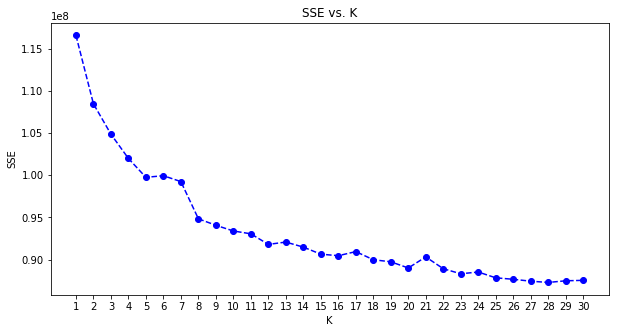

In [195]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(10, 5))
ax = plt.subplot()
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.xticks(np.arange(1, 31, step=1))
plt.ylabel('SSE');
plt.title('SSE vs. K');

#### Create cluster

Apply K-Means with `N_CLUSTERS` to customer and general population,

In [177]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
N_CLUSTERS = 20

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_jobs=-1)
azdias_preds = kmeans.fit_predict(reduced_data_new_azdias)

In [178]:
cluster_new_azdias_reduced_data_df = new_azdias_reduced_data_df.copy()
cluster_new_azdias_reduced_data_df['Cluster'] = azdias_preds
cluster_new_azdias_reduced_data_df.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 192,Dimension 193,Dimension 194,Dimension 195,Dimension 196,Dimension 197,Dimension 198,Dimension 199,Dimension 200,Cluster
0,2.465658,3.241744,0.655743,-1.383134,-2.786326,0.494273,0.460986,-1.163938,-2.628822,-1.345881,...,0.034714,0.254581,-0.152069,0.165396,-0.026687,-0.020962,-0.478874,-0.316404,0.076244,9
1,-1.577518,2.867757,-1.162584,0.485385,-2.403971,-0.300224,-2.024467,-0.520261,-0.275576,-1.357930,...,0.200241,-0.162420,-0.404268,-0.300968,-0.426807,0.078638,0.500249,-0.390566,-0.226182,9
2,-1.469129,2.049285,9.573081,2.719217,5.306097,-5.316458,1.763527,-0.054301,-0.752876,0.168237,...,-0.260120,0.792920,-0.136368,-0.252536,-0.234461,-0.073502,0.560000,-0.097685,0.417367,18
3,-3.478003,1.890868,-0.549728,0.675535,-1.424338,-0.573406,-0.901753,0.520831,-3.133695,-0.025872,...,-0.380170,0.021323,0.004814,-0.202649,-0.432441,0.192495,-0.558804,0.677313,0.397849,11
4,-0.573438,-1.372946,0.299852,-4.620116,-0.922874,0.149156,-3.913256,0.391566,-0.565959,-2.409920,...,0.059129,0.734993,0.245477,-0.688869,0.188748,0.366338,-0.120988,0.525035,-0.080384,9


In [179]:
customers_preds = kmeans.fit_predict(reduced_data_new_customers)

In [180]:
cluster_new_customers_reduced_data_df = new_customers_reduced_data_df.copy()
cluster_new_customers_reduced_data_df['Cluster'] = customers_preds
cluster_new_customers_reduced_data_df.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 192,Dimension 193,Dimension 194,Dimension 195,Dimension 196,Dimension 197,Dimension 198,Dimension 199,Dimension 200,Cluster
0,-2.956595,3.154275,-1.987066,-1.489638,0.598397,0.460184,-1.143192,-1.205614,-1.654281,0.899816,...,-0.120563,0.480649,-0.546017,0.431244,0.729968,0.431066,1.139930,-0.532727,-0.412491,5
1,4.891259,1.660363,-2.127063,-2.824312,2.563298,-2.679319,0.603507,-0.364002,2.741046,0.124429,...,-0.273646,0.150729,-0.418284,0.030661,0.440070,-0.314638,0.083985,-0.140619,0.183202,10
2,-1.858557,-1.741151,-1.663009,1.517244,-2.718060,-2.002800,0.210135,-0.906235,-0.869476,0.186217,...,0.034059,0.464904,-0.103650,0.180127,-0.894892,-0.139145,0.746033,-0.556759,-0.173011,12
3,5.867271,-0.971619,1.773567,-3.390000,-1.762156,-1.359707,-1.122974,0.533790,0.370678,-3.356769,...,-0.005487,-0.247592,0.352220,-0.116433,0.483877,-0.029923,0.304587,0.103605,-0.132550,8
4,0.227988,6.228427,-1.275258,0.306407,0.892103,-1.385209,-0.442024,0.648671,-0.482689,-0.992771,...,-0.217288,0.126846,-0.149660,0.613081,-0.478486,0.763496,0.376432,-0.444843,-0.181192,2


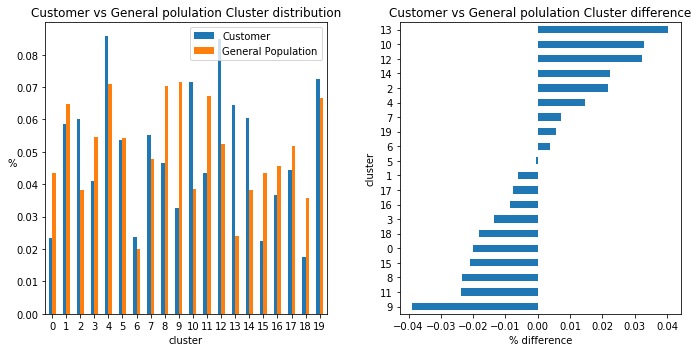

In [181]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(121)
pd.DataFrame({'Customer': pd.Series(customers_preds).value_counts()/customers_preds.size, 'General Population': pd.Series(azdias_preds).value_counts()/azdias_preds.size}).plot.bar(rot=0, ax=ax1)
plt.xlabel('cluster')
plt.ylabel('%').set_rotation(0)
plt.title('Customer vs General polulation Cluster distribution')

ax2 = plt.subplot(122)
(pd.Series(customers_preds).value_counts()/customers_preds.size - pd.Series(azdias_preds).value_counts()/azdias_preds.size).sort_values().plot.barh(ax=ax2)
plt.xlabel('% difference')
plt.ylabel('cluster')
plt.title('Customer vs General polulation Cluster difference')

plt.tight_layout()
plt.show()

#### Inverse transform

Map N cluster to original space. Then, select 2 cluster as target, for most customer like, and non-target, lest customer like. Finally, compare over and under represented features between these 2 culsters.

In [182]:
TARGET_CLUSTER = 0 # customer most like

# select cluster
target_cluster = cluster_new_azdias_reduced_data_df[cluster_new_azdias_reduced_data_df['Cluster'] == TARGET_CLUSTER]
target_cluster = target_cluster.drop('Cluster', axis=1)

# Perform inverse PCA and inverse scaling to return to the original values
target_cluster = new_azdias_pca.inverse_transform(target_cluster)
target_cluster = pd.DataFrame(scaler.inverse_transform(target_cluster), columns=new_azdias_df.columns)
target_cluster.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,WOHNLAGE_rural_40.0,WOHNLAGE_rural_50.0,WOHNLAGE_rural_60.0,WOHNLAGE_rural_70.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
0,0.740785,4.368576,-0.042062,0.131537,-0.034170,1.608148,2.278221,-0.011249,3.330569,5.794015,...,0.930346,0.016018,-0.090366,0.144002,0.728777,0.244226,0.079426,-0.105533,-0.058086,0.111190
1,0.898935,4.420320,0.960392,0.387754,-0.004825,0.191705,2.360920,-0.003651,-0.556402,5.979595,...,0.029810,0.041498,0.874131,0.054561,0.100547,0.059397,0.901628,0.071773,-0.068306,-0.065039
2,0.782521,2.954151,0.985398,0.095640,0.000183,1.396671,1.750613,0.000666,3.189368,4.972333,...,0.014956,-0.048947,1.005122,0.028870,0.042088,0.135034,-0.093884,0.884157,0.132083,-0.099477
3,1.003137,3.313605,1.067034,0.688101,-0.015266,0.129279,1.109065,-0.004804,-0.835002,5.890634,...,-0.234840,-0.099903,1.287799,0.046944,0.171359,0.005340,0.008020,0.085793,0.584381,0.145107
4,1.340635,3.087220,-0.087136,0.335781,0.004301,0.026233,2.274395,0.008973,4.640675,3.285251,...,1.024908,-0.123064,0.020723,0.077432,0.357822,0.313745,0.095817,0.112499,0.206838,-0.086722


In [183]:
NON_TARGET_CLUSTER = 12 # customer lest like

# select cluster
non_target_cluster = cluster_new_azdias_reduced_data_df[cluster_new_azdias_reduced_data_df['Cluster'] == NON_TARGET_CLUSTER]
non_target_cluster = non_target_cluster.drop('Cluster', axis=1)

# Perform inverse PCA and inverse scaling to return to the original values
non_target_cluster = new_azdias_pca.inverse_transform(non_target_cluster)
non_target_cluster = pd.DataFrame(scaler.inverse_transform(non_target_cluster), columns=new_azdias_df.columns)
non_target_cluster.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,WOHNLAGE_rural_40.0,WOHNLAGE_rural_50.0,WOHNLAGE_rural_60.0,WOHNLAGE_rural_70.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
0,1.305880,3.049511,0.856376,1.323565,0.013706,-0.170201,1.757192,-0.003689,5.085910,3.817419,...,0.188853,0.017229,0.807888,-0.013969,0.211270,0.032310,0.038734,0.059472,0.555272,0.102942
1,1.735228,4.642495,-0.003189,1.328033,0.020397,0.066989,1.100630,0.001216,4.576861,3.449246,...,0.248474,0.078222,0.642687,0.030617,-0.019582,0.040830,0.986663,-0.095816,0.012376,0.075529
2,1.800530,3.458757,0.947820,0.754523,0.028872,0.106120,1.102091,0.001152,5.330122,4.994700,...,0.165457,0.026648,0.794083,0.013812,-0.042826,0.036155,-0.059563,0.843206,0.012216,0.210812
3,1.763046,3.600390,0.886625,0.861496,0.024047,0.019669,1.056406,-0.003831,4.912069,1.242911,...,0.190608,0.069986,0.785807,-0.046401,0.212135,-0.024384,0.195547,-0.006201,0.575623,0.047279
4,0.794017,3.454593,0.003142,1.745544,0.053424,0.074285,1.114183,-0.004254,4.832892,0.713790,...,-0.076642,0.945224,0.088593,0.042825,0.107841,-0.007617,0.090729,0.026828,0.694541,0.087678


In [184]:
TARGET_COLUMNS = [
    # first principal component positive
    'PLZ8_ANTG3', # number of 6-10 family houses in the PLZ8)
    'PLZ8_ANTG4', # number of >10 family houses in the PLZ
    
    # first principal component negative
    'PLZ8_ANTG1', # number of 1-2 family houses in the PLZ8
    'KBA13_AUTOQUOTE', # share of cars per household within the PLZ8
    'PLZ8_GBZ', # number of buildings within the PLZ8
    'KBA13_ALTERHALTER_60', # share of car owners between 46 and 60 within the PLZ8
    
    # second principal component positive
    'KBA13_KMH_211', # share of cars with a greater max speed than 210 km/h within the PLZ8
    'KBA13_KMH_250', # share of cars with max speed between 210 and 250 km/h within the PLZ8
    'KBA13_SEG_SPORTWAGEN', # share of sportscars within the PLZ8
    'KBA13_HERST_BMW_BENZ', # share of BMW & Mercedes Benz within the PLZ8
    'KBA13_MERCEDES', # share of MERCEDES within the PLZ8
    
    # second principal component negative
    'KBA13_SITZE_5', # number of cars with 5 seats in the PLZ8
    'KBA13_KMH_140_210', # share of cars with max speed between 140 and 210 km/h within the PLZ8
    'KBA13_CCM_0_1400', # share of cars with less than 1400ccm within the PLZ8
    'KBA13_HALTER_20', # share of car owners below 21 within the PLZ8
    'KBA13_KW_50', # share of cars with an engine power between 41 and 50 KW - PLZ8
    
    # third principal component positive
    'D19_BANKEN_ONLINE_QUOTE_12', # amount of online transactions within all transactions in the segment bank
    'SEMIO_REL', # affinity indicating in what way the person is religious
    'ONLINE_AFFINITAET', # online affinity
    'SEMIO_RAT', # affinity indicating in what way the person is of a rational mind
    
    # third principal component negative
    'WOHNDAUER_2008', # length of residence
    'ALTERSKATEGORIE_GROB' # age classification through prename analysis
]

In [185]:
target_cluster[TARGET_COLUMNS].describe()

,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_ANTG1,KBA13_AUTOQUOTE,PLZ8_GBZ,KBA13_ALTERHALTER_60,KBA13_KMH_211,KBA13_KMH_250,KBA13_SEG_SPORTWAGEN,KBA13_HERST_BMW_BENZ,...,KBA13_KMH_140_210,KBA13_CCM_0_1400,KBA13_HALTER_20,KBA13_KW_50,D19_BANKEN_ONLINE_QUOTE_12,SEMIO_REL,ONLINE_AFFINITAET,SEMIO_RAT,WOHNDAUER_2008,ALTERSKATEGORIE_GROB
count,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,...,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000,31493.000000
mean,-0.210000,-0.836883,4.026315,4.144929,5.029483,4.046893,1.992741,1.999549,1.829278,3.141425,...,2.912110,0.147399,3.181561,0.356794,0.019083,2.911055,3.795395,2.821633,8.461760,3.914857
std,0.607800,0.336098,0.684982,1.564509,0.837927,1.656107,2.626899,2.630689,2.635352,0.764925,...,0.845539,2.655460,0.863291,2.741952,0.291164,1.720377,0.629044,1.536300,1.337070,0.476938
min,-1.250536,-1.174382,1.914809,-1.901104,1.762925,-1.510533,-3.374280,-3.535506,-3.098163,0.539010,...,0.659153,-4.079694,0.856531,-4.194007,-0.037190,-0.552414,1.431260,-0.654277,0.985578,2.619951
25%,-0.870809,-1.003126,3.847066,3.031656,4.019369,2.930892,0.894269,0.923506,0.966821,2.795322,...,2.075125,-2.003493,2.960208,-1.990312,-0.004460,1.835432,3.360510,1.646904,8.981120,3.522294
50%,-0.060437,-0.976026,4.016300,3.544457,4.990730,3.604982,2.893241,2.903548,2.968818,3.058158,...,2.989275,0.014938,3.013124,0.031785,0.000078,2.893054,3.871668,2.844387,8.997831,4.004349
75%,0.073239,-0.939243,4.769780,5.046466,5.949639,5.111098,3.135844,3.127640,3.018676,3.706594,...,3.065202,2.000552,3.969287,2.009248,0.004724,3.862451,4.286347,3.761694,9.007708,4.229628
max,2.129626,1.102761,5.218519,7.965616,6.116981,8.497095,7.493677,7.390475,7.108264,5.365765,...,5.179556,6.081789,5.164904,6.078628,6.999931,6.753332,5.339939,6.830351,9.051358,5.256435


In [186]:
non_target_cluster[TARGET_COLUMNS].describe()

,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_ANTG1,KBA13_AUTOQUOTE,PLZ8_GBZ,KBA13_ALTERHALTER_60,KBA13_KMH_211,KBA13_KMH_250,KBA13_SEG_SPORTWAGEN,KBA13_HERST_BMW_BENZ,...,KBA13_KMH_140_210,KBA13_CCM_0_1400,KBA13_HALTER_20,KBA13_KW_50,D19_BANKEN_ONLINE_QUOTE_12,SEMIO_REL,ONLINE_AFFINITAET,SEMIO_RAT,WOHNDAUER_2008,ALTERSKATEGORIE_GROB
count,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,...,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000,38020.000000
mean,1.850938,0.760961,2.004785,-0.658650,3.134766,-0.047892,1.460380,1.491594,1.784356,3.166327,...,2.863447,1.646815,2.137906,1.335358,0.001270,3.649925,2.347117,3.262128,8.561016,3.782882
std,0.335479,0.410447,0.217892,0.865801,0.723134,1.336208,2.521546,2.539973,2.729545,0.783284,...,0.776155,2.618293,1.003262,2.771179,0.068170,1.895467,0.770847,1.693888,0.953823,0.491089
min,-1.348084,-1.336863,0.848158,-2.963143,1.602544,-1.865217,-3.377977,-3.639874,-3.122190,0.630140,...,0.821307,-4.072328,0.836662,-4.163043,-0.029940,-0.596333,0.742943,-0.536489,2.971371,2.682147
25%,1.885419,0.527770,1.973122,-1.175009,2.951478,-1.076852,0.848418,0.881344,0.940987,2.773921,...,2.055636,0.011442,1.041015,-0.004561,-0.003281,2.102519,1.784377,1.979622,8.042342,3.369575
50%,1.961865,0.979825,2.003240,-0.954728,3.010147,-0.644649,2.713856,2.620130,2.944455,3.076127,...,2.986254,1.996052,2.002569,1.990843,0.000205,3.338195,2.236248,3.046869,8.996872,3.891782
75%,2.020802,1.014433,2.032567,-0.682740,3.957810,0.899563,3.002337,3.070207,3.018483,3.757291,...,3.055196,3.968447,2.988113,2.036676,0.003592,5.603050,2.750552,4.079383,9.009024,4.140235
max,2.468419,1.162247,4.036915,5.527466,6.041397,7.034883,7.396608,7.397398,7.109966,5.494673,...,5.102041,6.064390,5.113482,6.074223,5.996304,6.807640,5.187276,6.867139,9.052419,5.488001


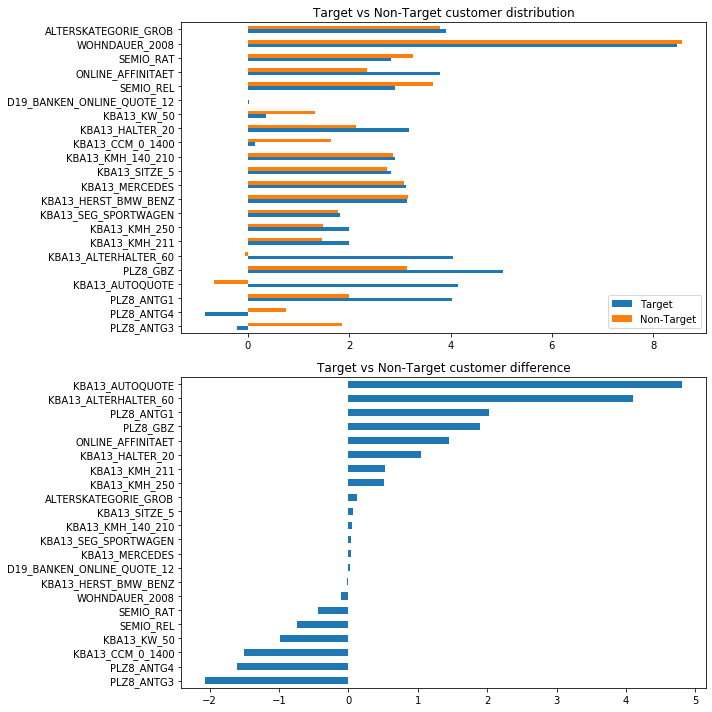

In [188]:
# find mean value to compare difference of each cluster
mean_target_cluster = target_cluster[TARGET_COLUMNS].describe().loc['mean']
mean_non_target_cluster = non_target_cluster[TARGET_COLUMNS].describe().loc['mean']

# draw distribution bar chart
mean_df = pd.concat([mean_target_cluster, mean_non_target_cluster], axis=1)
mean_df.columns = ['Target', 'Non-Target']
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(211)
mean_df.plot.barh(ax=ax1)
plt.title('Target vs Non-Target customer distribution')

# draw difference bar chart
ax2 = plt.subplot(212)
(mean_df['Target'] - mean_df['Non-Target']).sort_values().plot.barh(ax=ax2)
plt.title('Target vs Non-Target customer difference')

plt.tight_layout()
plt.show()

**Customer characteristics more than average Top 5**
* SEMIO_REL: affinity indicating in what way the person is religious (high to low)
* SEMIO_RAT: affinity indicating in what way the person is of a rational mind (high to low)
* KBA13_KMH_211: share of cars with a greater max speed than 210 km/h within the PLZ8 (low to high)
* KBA13_KMH_250: share of cars with max speed between 210 and 250 km/h within the PLZ8 (low to high)
* PLZ8_ANTG3: number of 6-10 family houses in the PLZ8 (low to high)

**Customer characteristics less than average Top 5**
* WOHNDAUER_2008: length of residence (low to high)
* KBA13_AUTOQUOTE: share of cars per household within the PLZ8 (low to high)
* KBA13_ALTERHALTER_60: share of car owners between 46 and 60 within the PLZ8 (low to high
* PLZ8_ANTG1: number of 1-2 family houses in the PLZ8 (low to high)
* PLZ8_GBZ: number of buildings within the PLZ8 (low to high)

### Conclusion

From above we can somehow come out the customer face as: less religious, less rational mind, love luxury car, live in middle size house building, less residence, less car owner between 46 and 60.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_train.head()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')